In [2]:
# Installing the needed librarires

pip install pandas matplotlib statsmodels scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [31]:
# (Base) This code defines a RedemptionModel class that performs time series forecasting using a seasonal decomposition baseline model, evaluating predictions via time series cross-validation with MAPE as the error metric. It also includes plotting functionality to visualize observed vs. predicted values over time.


import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt


class RedemptionModel:

    def __init__(self, X, target_col):
        '''
        Args:
        X (pandas.DataFrame): Dataset of predictors, output from load_data()
        target_col (str): column name for target variable
        '''
        self._predictions = {}
        self.X = X
        self.target_col = target_col
        self.results = {} # dict of dicts with model results

    def score(self, truth, preds):
        # Score our predictions - modify this method as you like
        return MAPE(truth, preds)


    def run_models(self, n_splits=4, test_size=365):
        '''Run the models and store results for cross validated splits in
        self.results.
        '''
        # Time series split
        tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size)
        cnt = 0 # keep track of splits
        for train, test in tscv.split(self.X):
            X_train = self.X.iloc[train]
            X_test = self.X.iloc[test]
            # Base model - please leave this here
            preds = self._base_model(X_train, X_test)
            if 'Base' not in self.results:
                self.results['Base'] = {}
            self.results['Base'][cnt] = self.score(X_test[self.target_col],
                                preds)
            self.plot(preds, 'Base')
            # Other models...
            # self._my-new-model(train, test) << Add your model(s) here
            cnt += 1


    def _base_model(self, train, test):
        '''
        Our base, too-simple model.
        Your model needs to take the training and test datasets (dataframes)
        and output a prediction based on the test data.

        Please leave this method as-is.

        '''
        res = sm.tsa.seasonal_decompose(train[self.target_col],
                                        period=365)
        res_clip = res.seasonal.apply(lambda x: max(0,x))
        res_clip.index = res_clip.index.dayofyear
        res_clip = res_clip.groupby(res_clip.index).mean()
        res_dict = res_clip.to_dict()
        return pd.Series(index = test.index, 
                         data = map(lambda x: res_dict[x], test.index.dayofyear))

    def plot(self, preds, label):
        # plot out the forecasts
        fig, ax = plt.subplots(figsize=(15, 5))
        ax.scatter(self.X.index, self.X[self.target_col], s=0.4, color='grey',
            label='Observed')
        ax.plot(preds, label = label, color='red')
        plt.legend()

Model Results: {'Base': {0: 0.8917838081113705, 1: 0.8535856042944977, 2: 0.8495029583241723, 3: 0.8582048204199051}}

Average Scores:
 Base    0.863269
dtype: float64


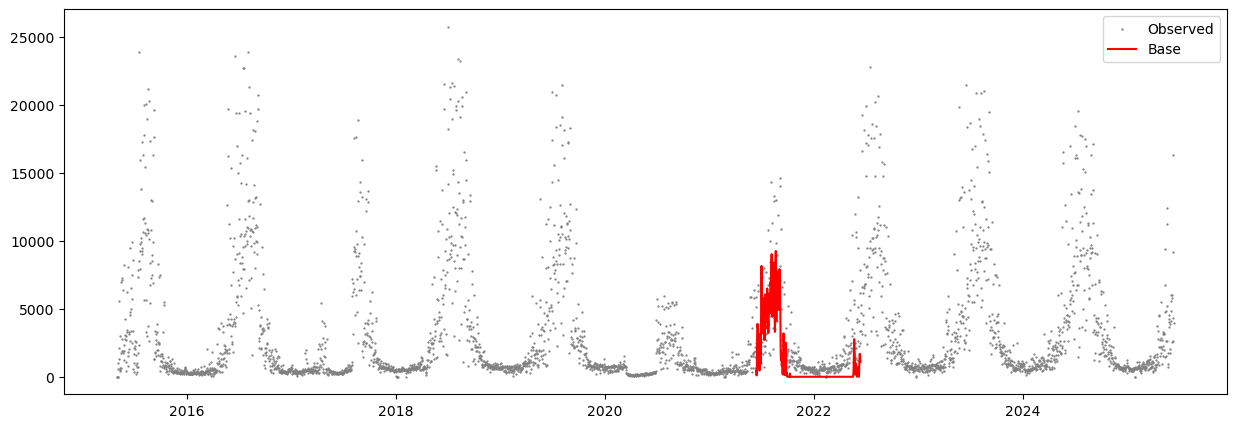

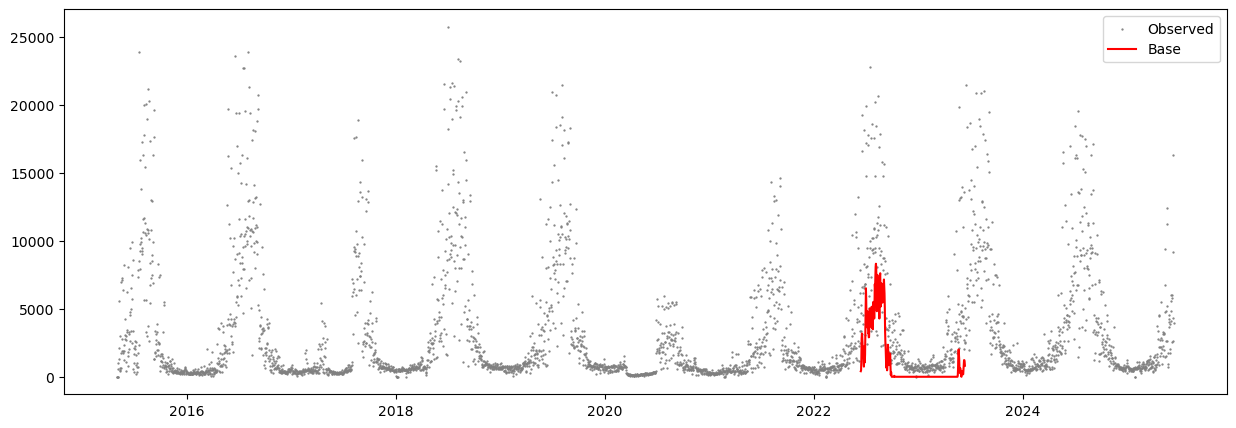

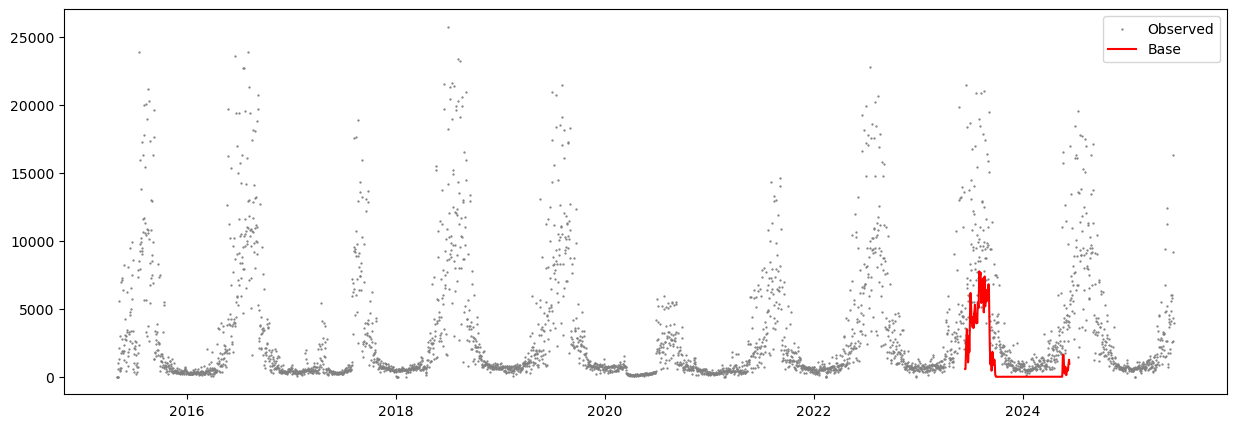

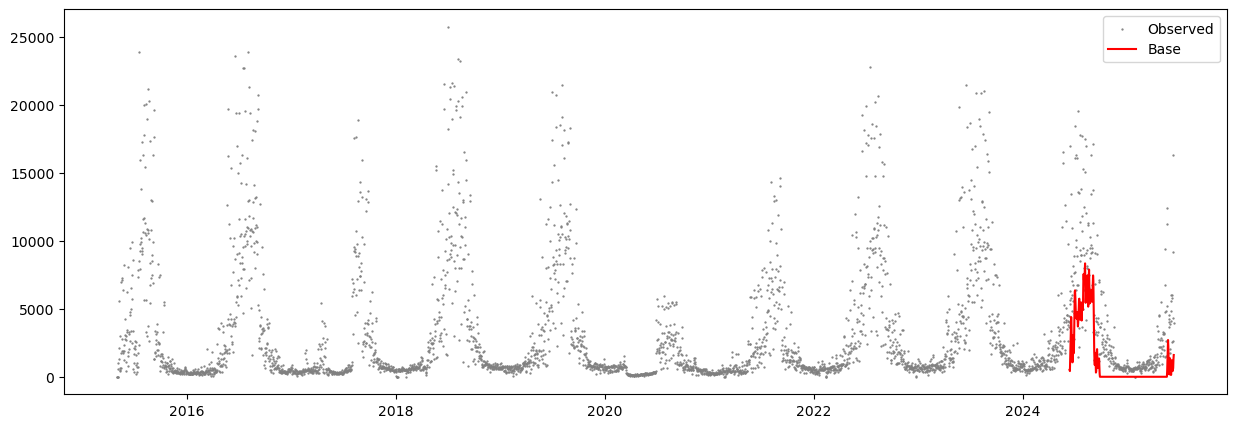

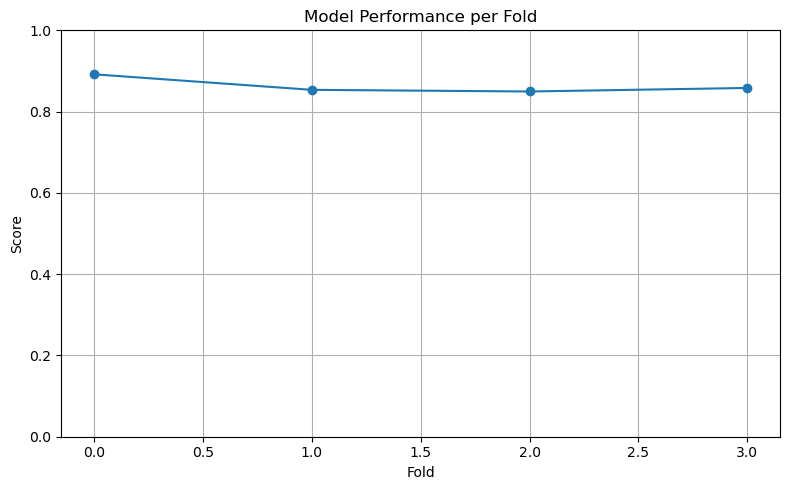

In [27]:
# This code loads and preprocesses daily time series data from a CSV file, then uses the previously defined RedemptionModel to run cross-validated forecasting models, prints their performance scores, and visualizes the model's error metric across the folds.

import sys
import pandas as pd
import matplotlib.pyplot as plt

# Add your project directory to Python's search path
sys.path.append(r'C:\ALL\Jobs\Other\Maged Eid - Applied Scientist in Data Science (SX2)')

# Import RedemptionModel class from Model.py
from Model import RedemptionModel

# Function to load and process the data
def load_data(file):
    df = pd.read_csv(file,
                     dtype={'_id': int, 'Redemption Count': int, 'Sales Count': int},
                     parse_dates=['Timestamp'])
    df.sort_values('Timestamp', inplace=True)
    df.set_index('Timestamp', inplace=True)
    df_daily = df.resample('d').sum()
    df_daily['monthly'] = df_daily.reset_index().Timestamp.dt.month.values
    df_daily['quarter'] = df_daily.reset_index().Timestamp.dt.quarter.values
    return df_daily

# Load the data
df = load_data(r'C:\ALL\Jobs\Other\Maged Eid - Applied Scientist in Data Science (SX2)\Toronto Island Ferry Ticket Counts.csv')

# Create and run the model
rm = RedemptionModel(df, 'Redemption Count')
rm.run_models()

# Print the results
print("Model Results:", rm.results)

# Convert to DataFrame for analysis
df_results = pd.DataFrame(rm.results)
print("\nAverage Scores:\n", df_results.mean())

# Plotting the results
plt.figure(figsize=(8, 5))
plt.plot(df_results.index, df_results['Base'], marker='o', linestyle='-')
plt.title("Model Performance per Fold")
plt.xlabel("Fold")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.show()


In [7]:
# This code loads a CSV dataset into a pandas DataFrame, prints basic information and the first 10 rows, provides summary statistics for the 'Redemption Count' column, counts how many values are zero or near zero, and checks for any missing values in the dataset.

import pandas as pd

file_path = r"C:\ALL\Jobs\Other\Maged Eid - Applied Scientist in Data Science (SX2)\Toronto Island Ferry Ticket Counts.csv"

# Load the data
df = pd.read_csv(file_path, parse_dates=['Timestamp'])

# Check basic info
print("DataFrame info:")
print(df.info())

# Show first 10 rows
print("\nFirst 10 rows:")
print(df.head(10))

# Summary statistics for Redemption Count
print("\n'Redemption Count' summary stats:")
print(df['Redemption Count'].describe())

# Count zero or near-zero values in Redemption Count
zero_count = (df['Redemption Count'] == 0).sum()
near_zero_count = (df['Redemption Count'] < 5).sum()
print(f"\nZero Redemption Counts: {zero_count}")
print(f"Near-zero (<5) Redemption Counts: {near_zero_count}")

# Check for missing values
missing_values = df.isna().sum()
print("\nMissing values per column:")
print(missing_values)


DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246818 entries, 0 to 246817
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   _id               246818 non-null  int64         
 1   Timestamp         246818 non-null  datetime64[ns]
 2   Redemption Count  246818 non-null  int64         
 3   Sales Count       246818 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 7.5 MB
None

First 10 rows:
   _id           Timestamp  Redemption Count  Sales Count
0    1 2025-06-11 14:45:00               212          199
1    2 2025-06-11 14:30:00               204          206
2    3 2025-06-11 14:15:00               211          165
3    4 2025-06-11 14:00:00               179          270
4    5 2025-06-11 13:45:00                98          150
5    6 2025-06-11 13:30:00               278          243
6    7 2025-06-11 13:15:00               253          212
7 

In [9]:
# This code loads raw 15-minute interval data, aggregates it to daily sums to reduce noise, engineers time-based features (like day of week, month, quarter, weekend flag), creates lag features for previous 1 and 7 days of 'Redemption Count', removes rows with missing lag values, and saves the cleaned dataset for further analysis or modeling.


import pandas as pd

# Load raw data
file_path = r'C:\ALL\Jobs\Other\Maged Eid - Applied Scientist in Data Science (SX2)\Toronto Island Ferry Ticket Counts.csv'
df = pd.read_csv(file_path, parse_dates=['Timestamp'])

# Aggregate 15-min data into daily sums to reduce noise
df_daily = df.set_index('Timestamp').resample('D').sum()

# Add time features
df_daily['day_of_week'] = df_daily.index.dayofweek  # Monday=0, Sunday=6
df_daily['month'] = df_daily.index.month
df_daily['quarter'] = df_daily.index.quarter
df_daily['is_weekend'] = df_daily['day_of_week'].isin([5,6]).astype(int)

# Add lag features (previous 1 day and previous 7 days Redemption Counts)
df_daily['RedemptionCount_lag1'] = df_daily['Redemption Count'].shift(1)
df_daily['RedemptionCount_lag7'] = df_daily['Redemption Count'].shift(7)

# Drop initial rows with NaN from lag features
df_daily = df_daily.dropna()

# Save cleaned data
output_path = r'C:\ALL\Jobs\Other\Maged Eid - Applied Scientist in Data Science (SX2)\Cleaned_SX2.csv'
df_daily.to_csv(output_path)

print("Cleaning and feature engineering done. Cleaned data saved to:", output_path)


Cleaning and feature engineering done. Cleaned data saved to: C:\ALL\Jobs\Other\Maged Eid - Applied Scientist in Data Science (SX2)\Cleaned_SX2.csv


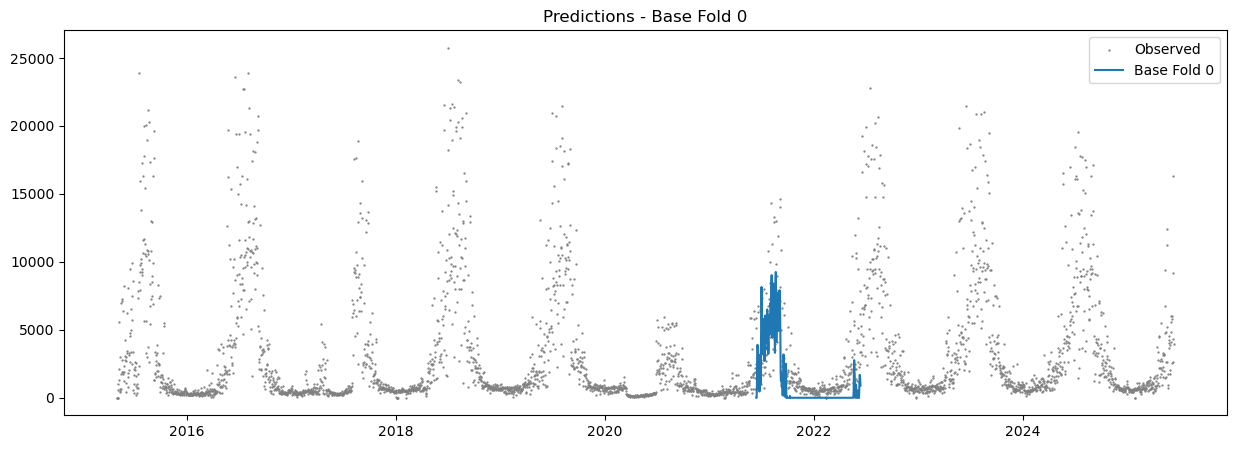

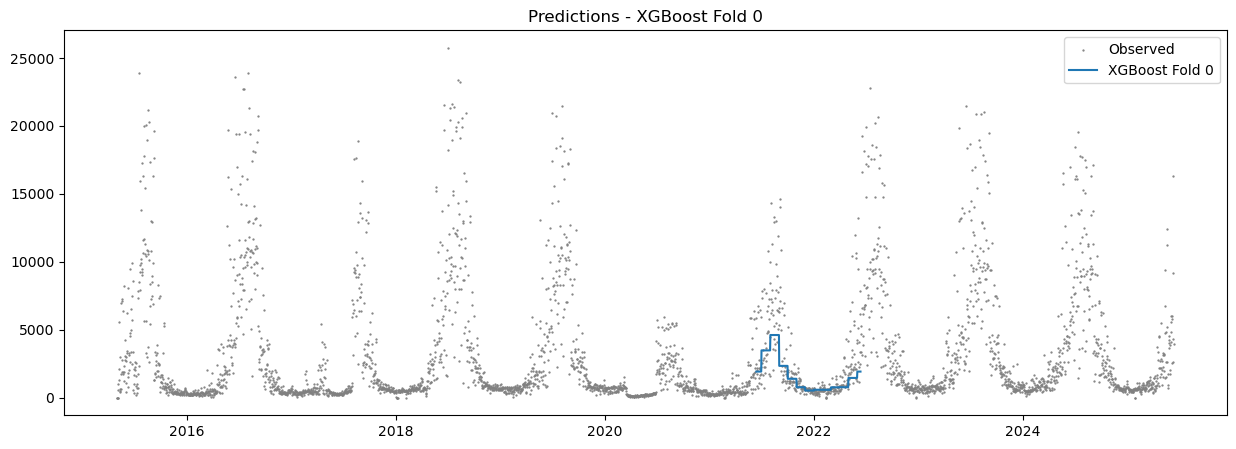

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000465 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 268
[LightGBM] [Info] Number of data points in the train set: 2235, number of used features: 2
[LightGBM] [Info] Start training from score 7.043045


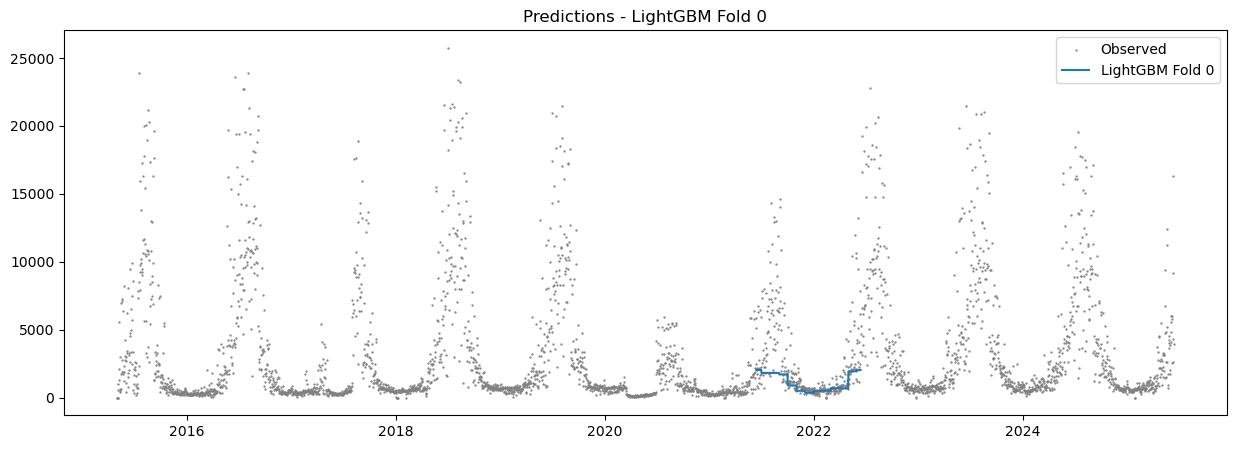

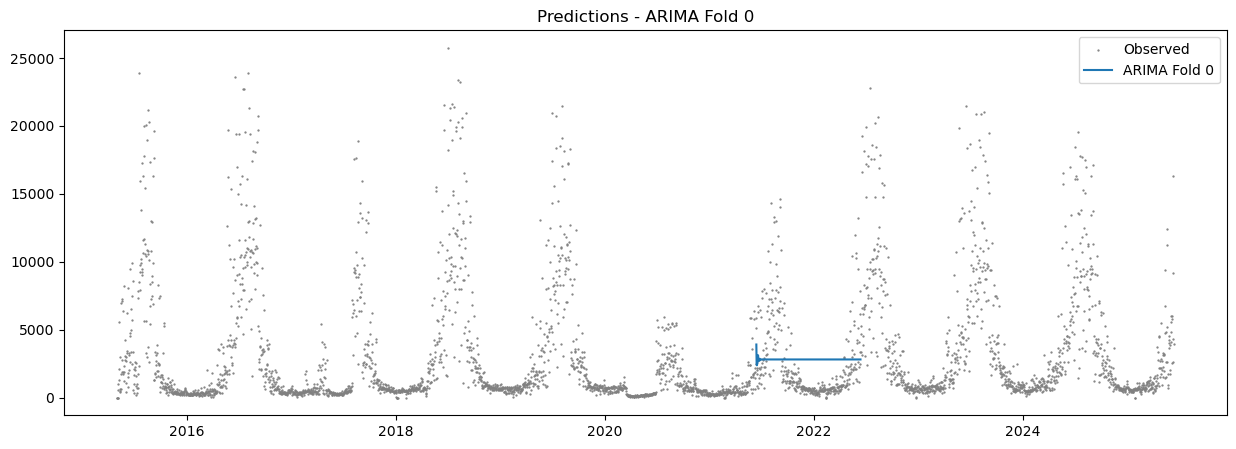

19:03:12 - cmdstanpy - INFO - Chain [1] start processing
19:03:13 - cmdstanpy - INFO - Chain [1] done processing


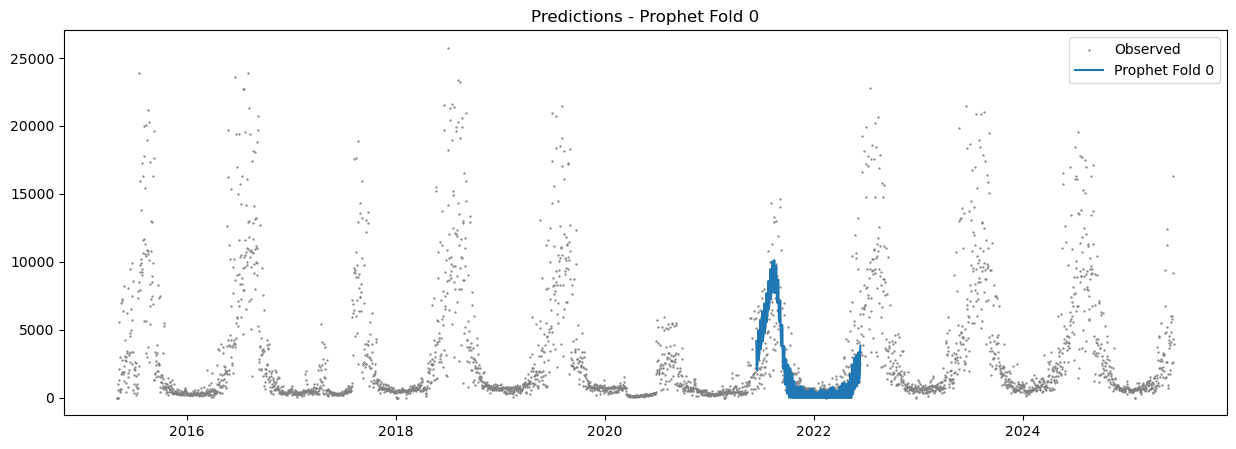

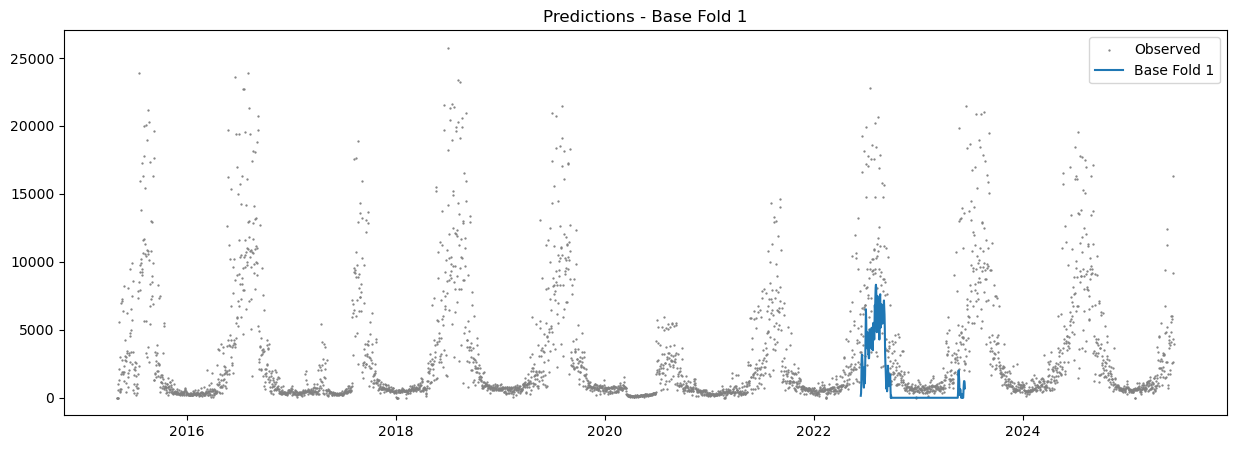

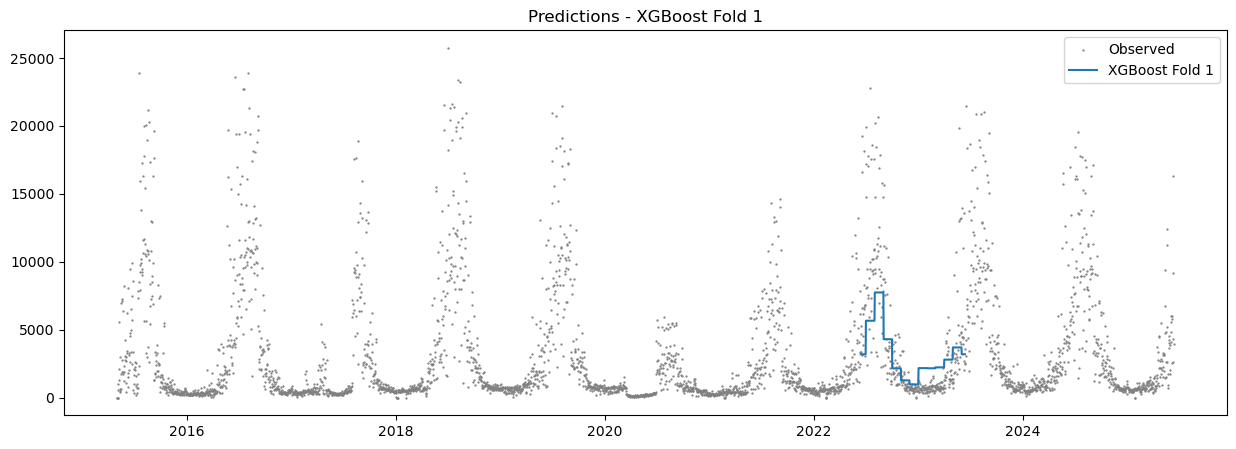

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 268
[LightGBM] [Info] Number of data points in the train set: 2600, number of used features: 2
[LightGBM] [Info] Start training from score 7.071544


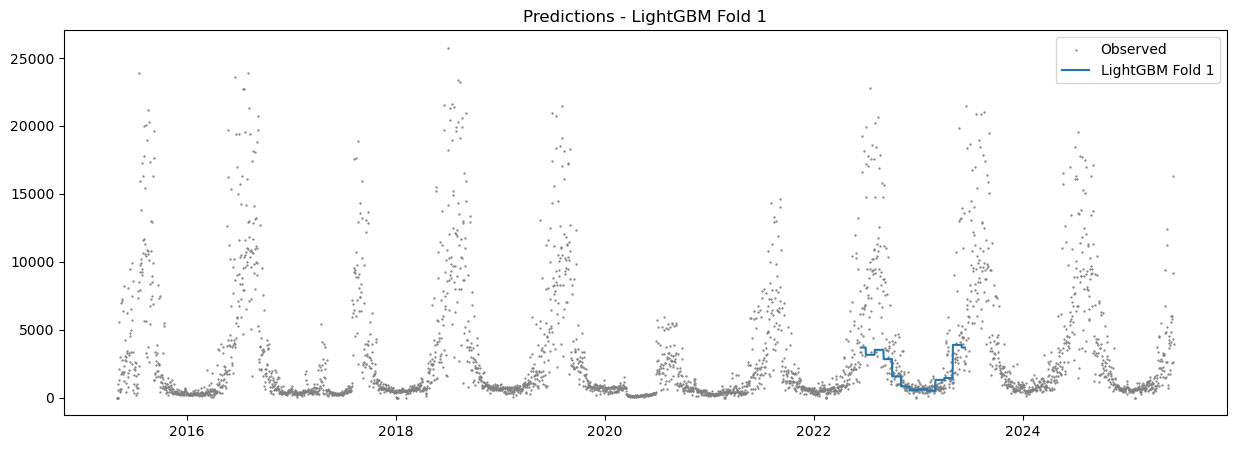

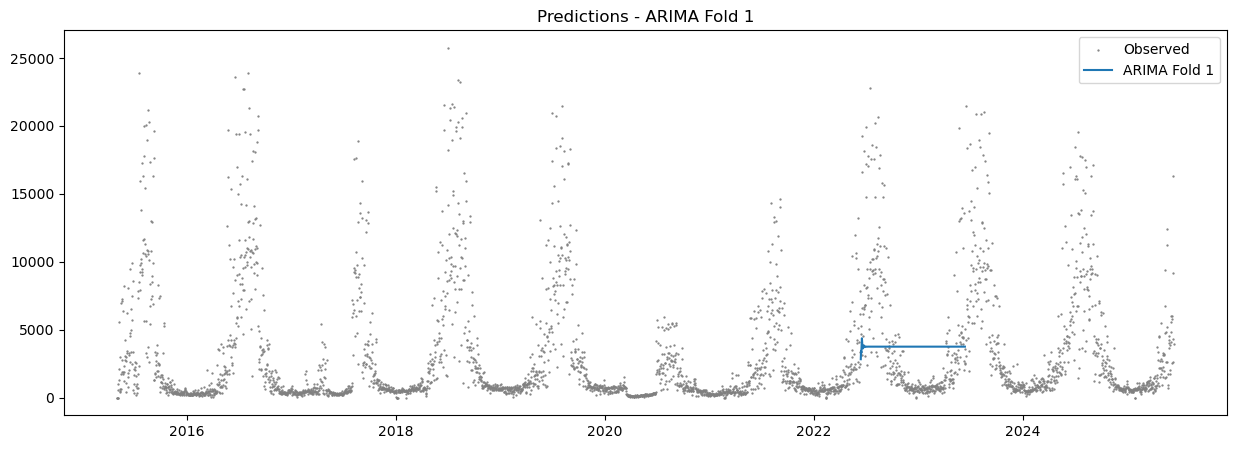

19:03:21 - cmdstanpy - INFO - Chain [1] start processing
19:03:21 - cmdstanpy - INFO - Chain [1] done processing


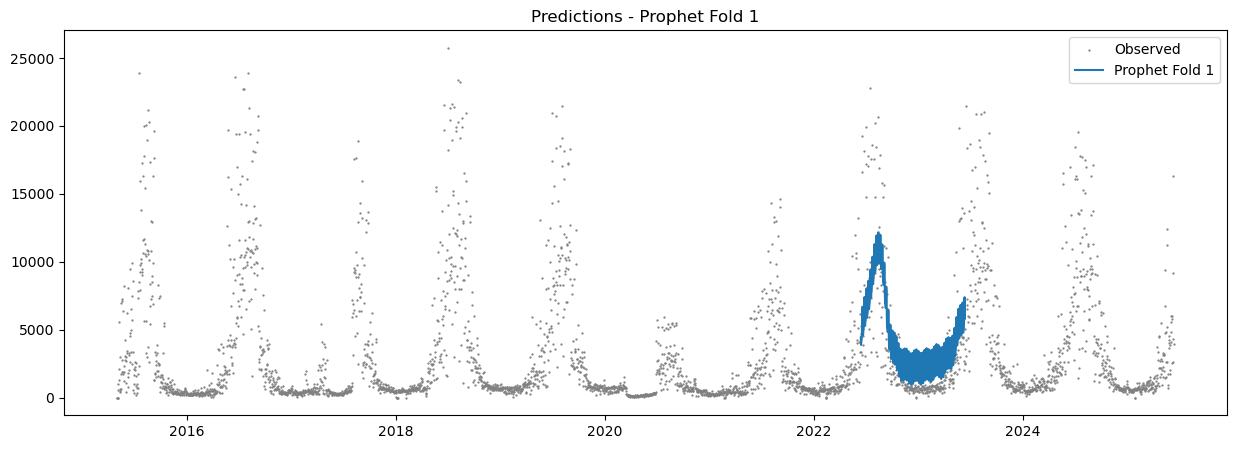

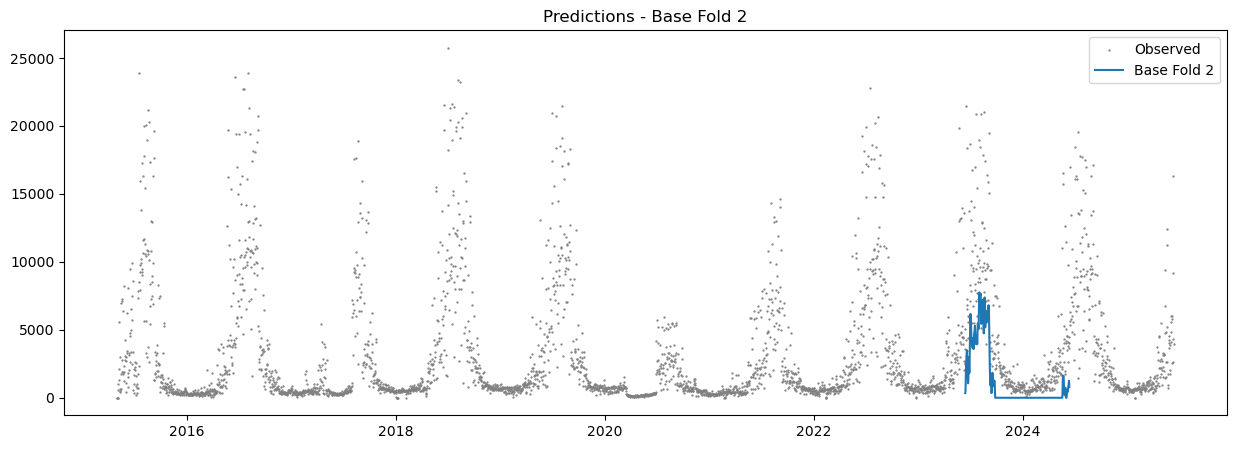

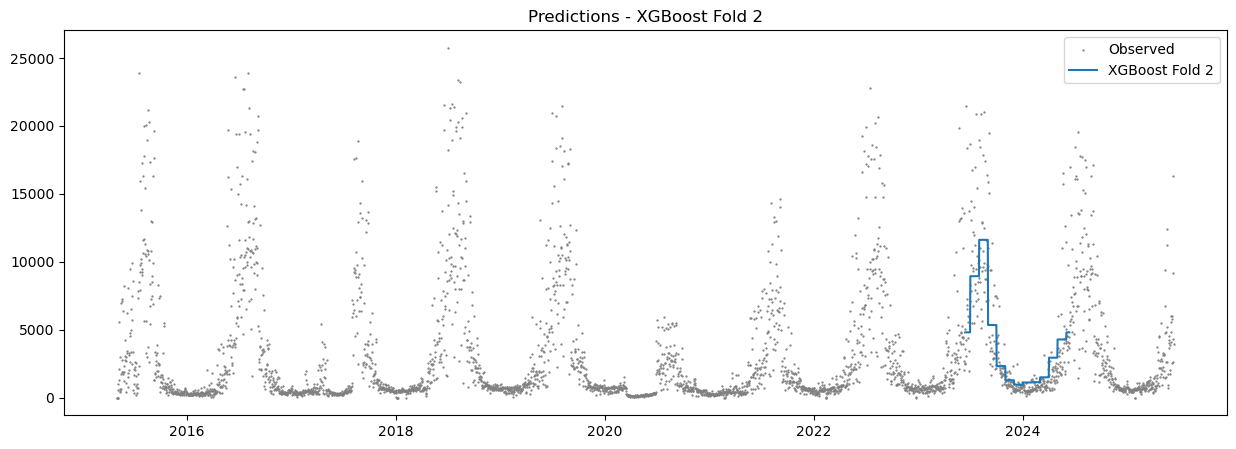

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000468 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 268
[LightGBM] [Info] Number of data points in the train set: 2965, number of used features: 2
[LightGBM] [Info] Start training from score 7.139438


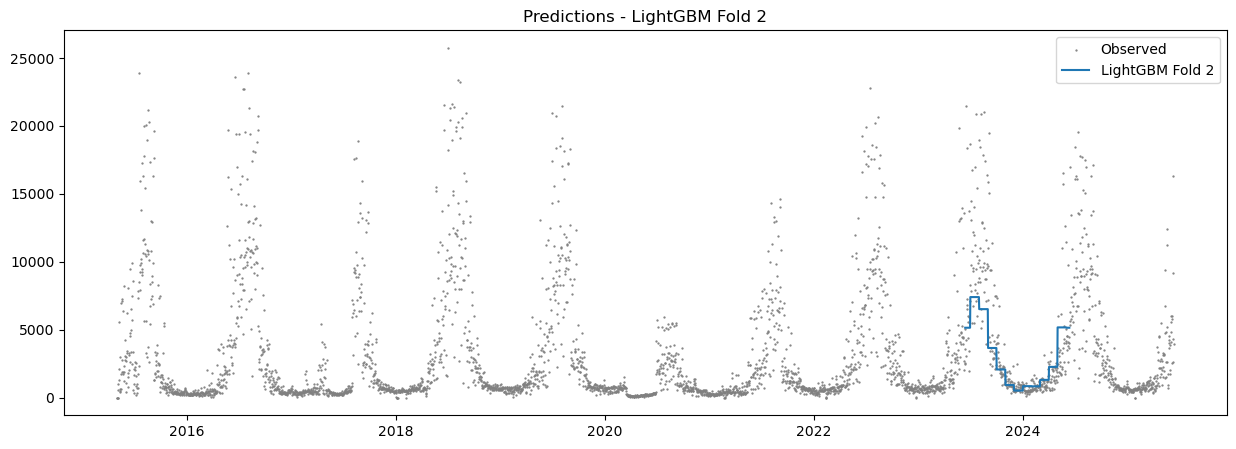

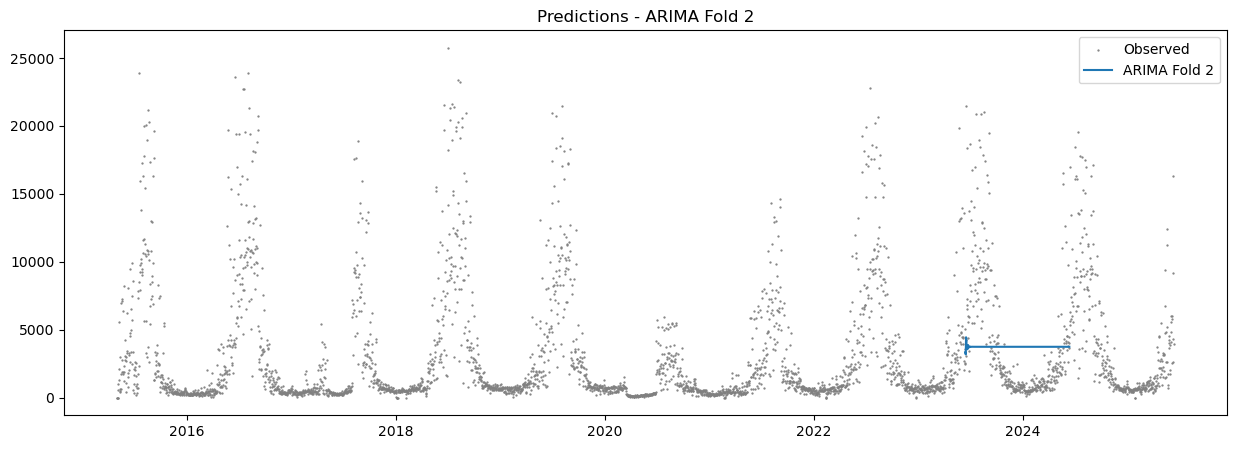

19:03:29 - cmdstanpy - INFO - Chain [1] start processing
19:03:29 - cmdstanpy - INFO - Chain [1] done processing


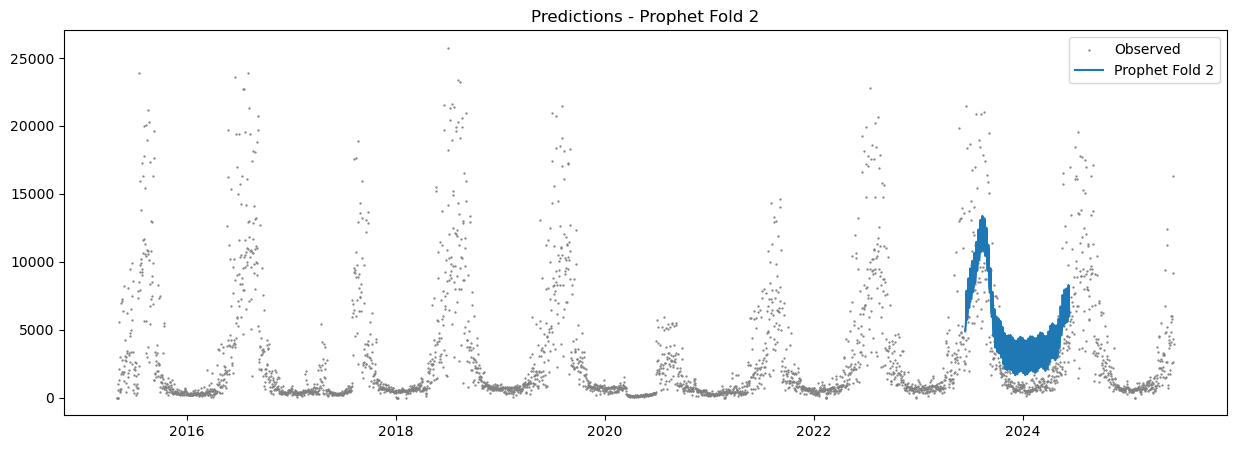

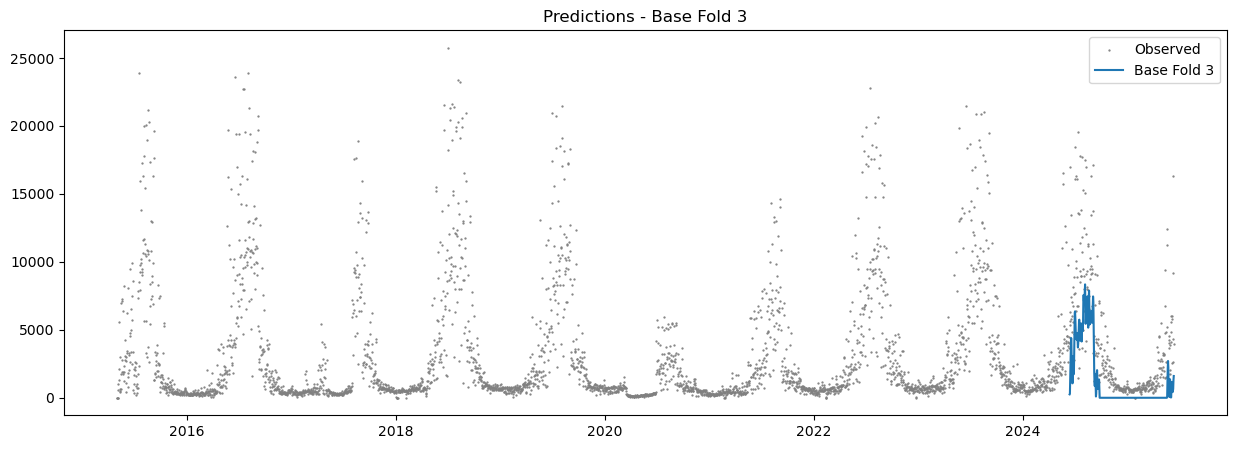

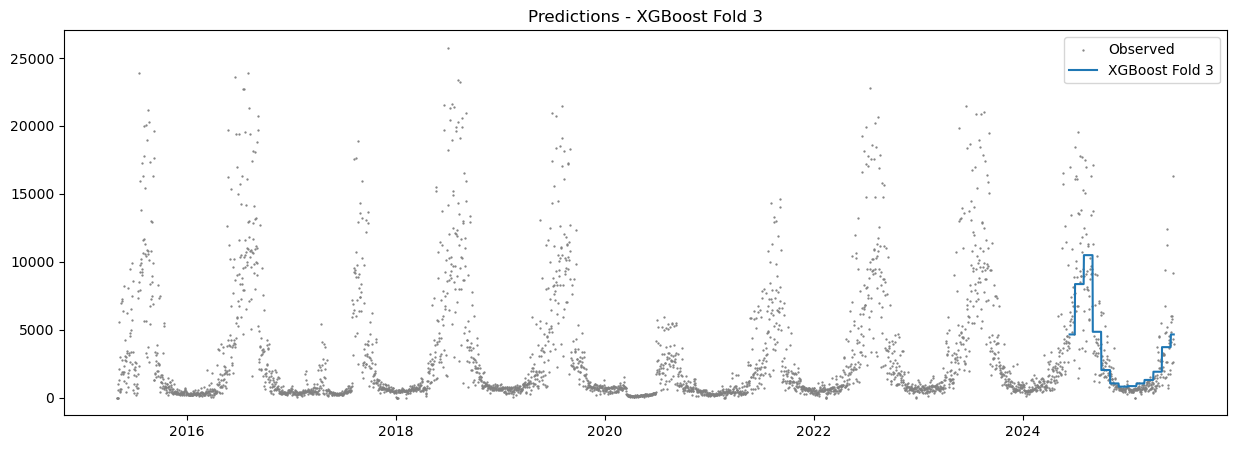

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 268
[LightGBM] [Info] Number of data points in the train set: 3330, number of used features: 2
[LightGBM] [Info] Start training from score 7.199405


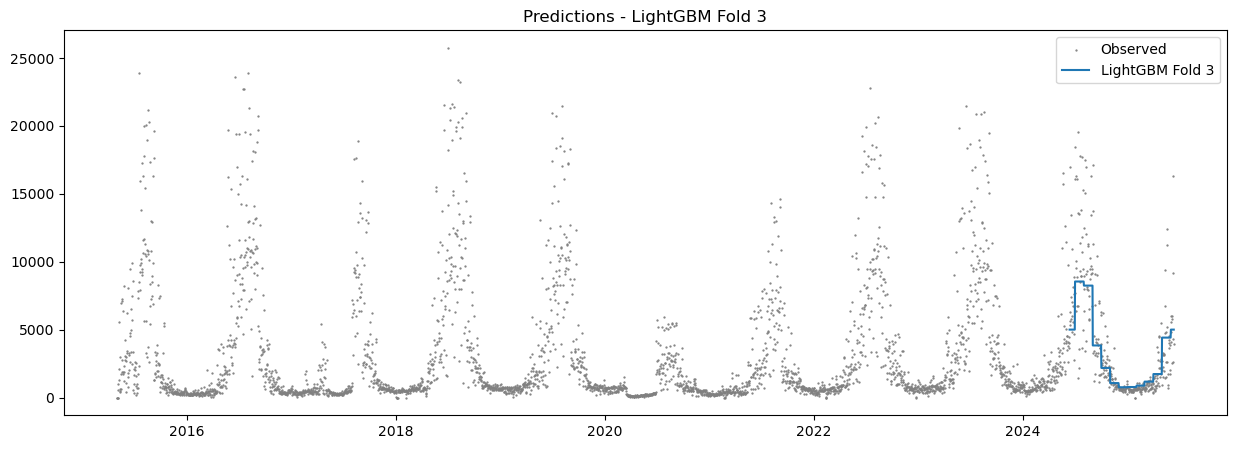

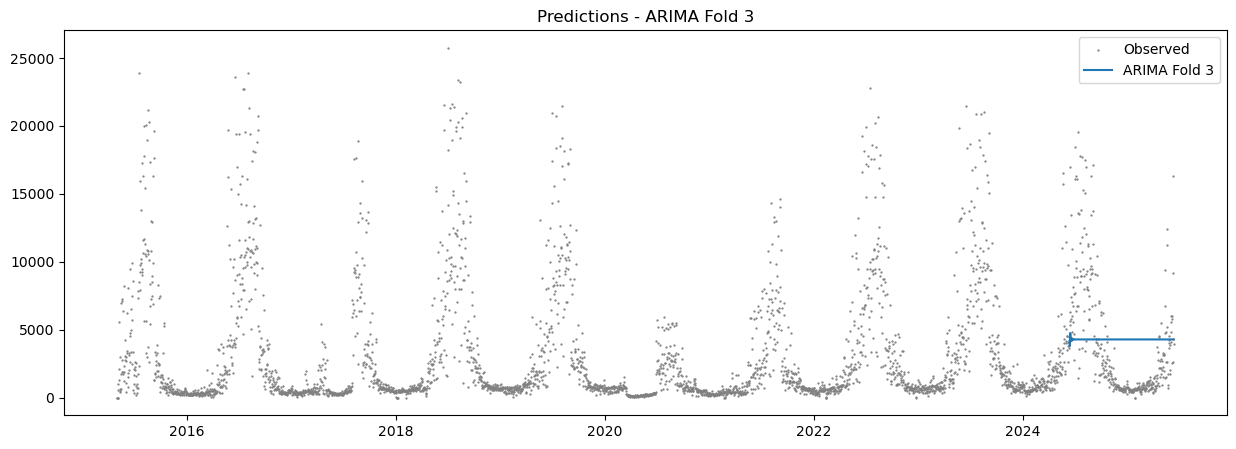

19:03:37 - cmdstanpy - INFO - Chain [1] start processing
19:03:38 - cmdstanpy - INFO - Chain [1] done processing


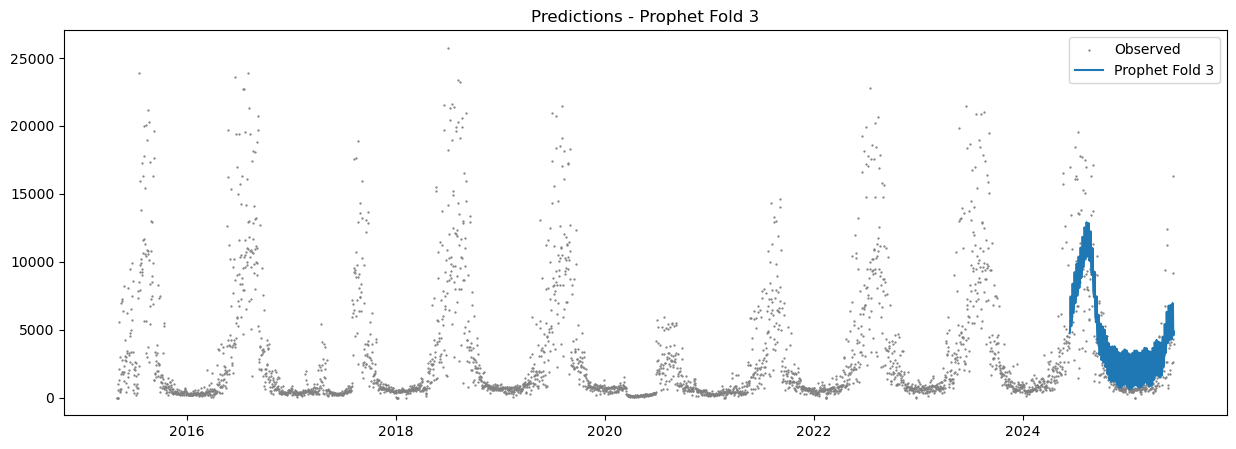

Model results keys: dict_keys(['Base', 'XGBoost', 'LightGBM', 'ARIMA', 'Prophet'])

Base Model Results per fold (MAPE):
Fold 0: 0.8963
Fold 1: 0.8563
Fold 2: 0.8514
Fold 3: 0.8605

XGBoost Model Results per fold (MAPE):
Fold 0: 14438572818350124.0000
Fold 1: 12143968866377526.0000
Fold 2: 0.6407
Fold 3: 21158393268075288.0000

LightGBM Model Results per fold (MAPE):
Fold 0: 12800840348719726.0000
Fold 1: 6986383643790709.0000
Fold 2: 0.4875
Fold 3: 19537092506809836.0000

ARIMA Model Results per fold (MAPE):
Fold 0: 69571779235733384.0000
Fold 1: 46403110392260664.0000
Fold 2: 2.2064
Fold 3: 105903816799374768.0000

Prophet Model Results per fold (MAPE):
Fold 0: 4712277130188111.0000
Fold 1: 43743947976778392.0000
Fold 2: 1.6689
Fold 3: 60375066683601056.0000


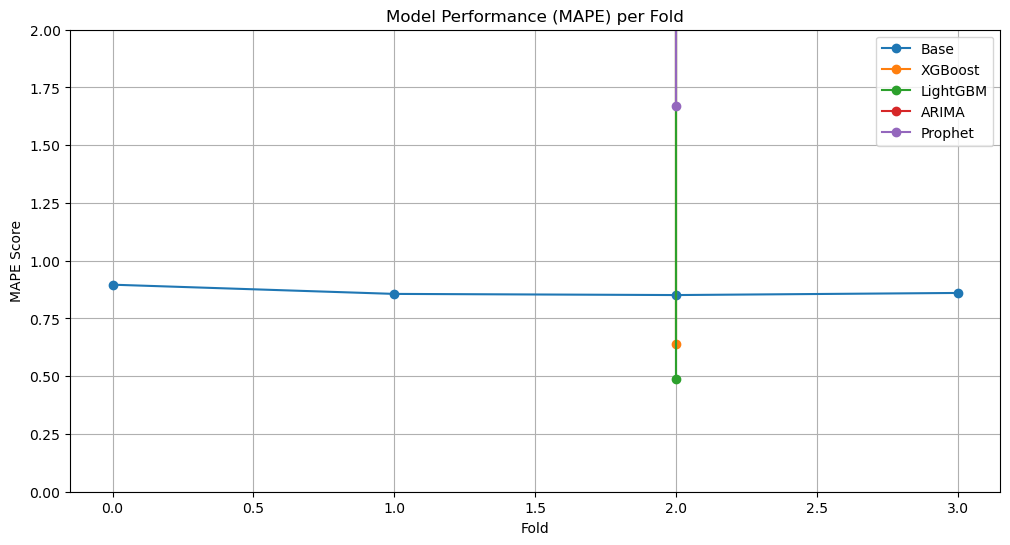

In [1]:
# This code loads and preprocesses time series data, initializes a custom RedemptionModel from Model_Maged.py, runs forecasting models using time series cross-validation, prints MAPE scores for each fold, and visualizes model performance across folds for comparison.

# Decided to work with the Original Dataset instead 


import sys
import pandas as pd
import matplotlib.pyplot as plt

# Add path where your Model_Maged.py is located
sys.path.append(r'C:\ALL\Jobs\Other\Maged Eid - Applied Scientist in Data Science (SX2)')

from Model_Maged import RedemptionModel

# Function to load and preprocess data
def load_data(file):
    df = pd.read_csv(file,
                     dtype={'_id': int, 'Redemption Count': int, 'Sales Count': int},
                     parse_dates=['Timestamp'])
    df.sort_values('Timestamp', inplace=True)
    df.set_index('Timestamp', inplace=True)
    df_daily = df.resample('D').sum()

    # Optional features for models like XGBoost and LightGBM
    df_daily['monthly'] = df_daily.index.month
    df_daily['quarter'] = df_daily.index.quarter
    return df_daily

# Path to your cleaned CSV file
file_path = r'C:\ALL\Jobs\Other\Maged Eid - Applied Scientist in Data Science (SX2)\Toronto Island Ferry Ticket Counts.csv'
df = load_data(file_path)

# Initialize and run all models
rm = RedemptionModel(df, 'Redemption Count')
rm.run_models()

# Display model results
print("Model results keys:", rm.results.keys())

for model_name, scores in rm.results.items():
    print(f"\n{model_name} Model Results per fold (MAPE):")
    for fold, score in scores.items():
        print(f"Fold {fold}: {score:.4f}")

# Plot comparison of MAPE scores
plt.figure(figsize=(12, 6))
for model_name, scores in rm.results.items():
    plt.plot(list(scores.keys()), list(scores.values()), marker='o', label=model_name)
plt.title('Model Performance (MAPE) per Fold')
plt.xlabel('Fold')
plt.ylabel('MAPE Score')
plt.ylim(0, 2)  # Adjust as needed
plt.grid(True)
plt.legend()
plt.show()


Training fold 1/4


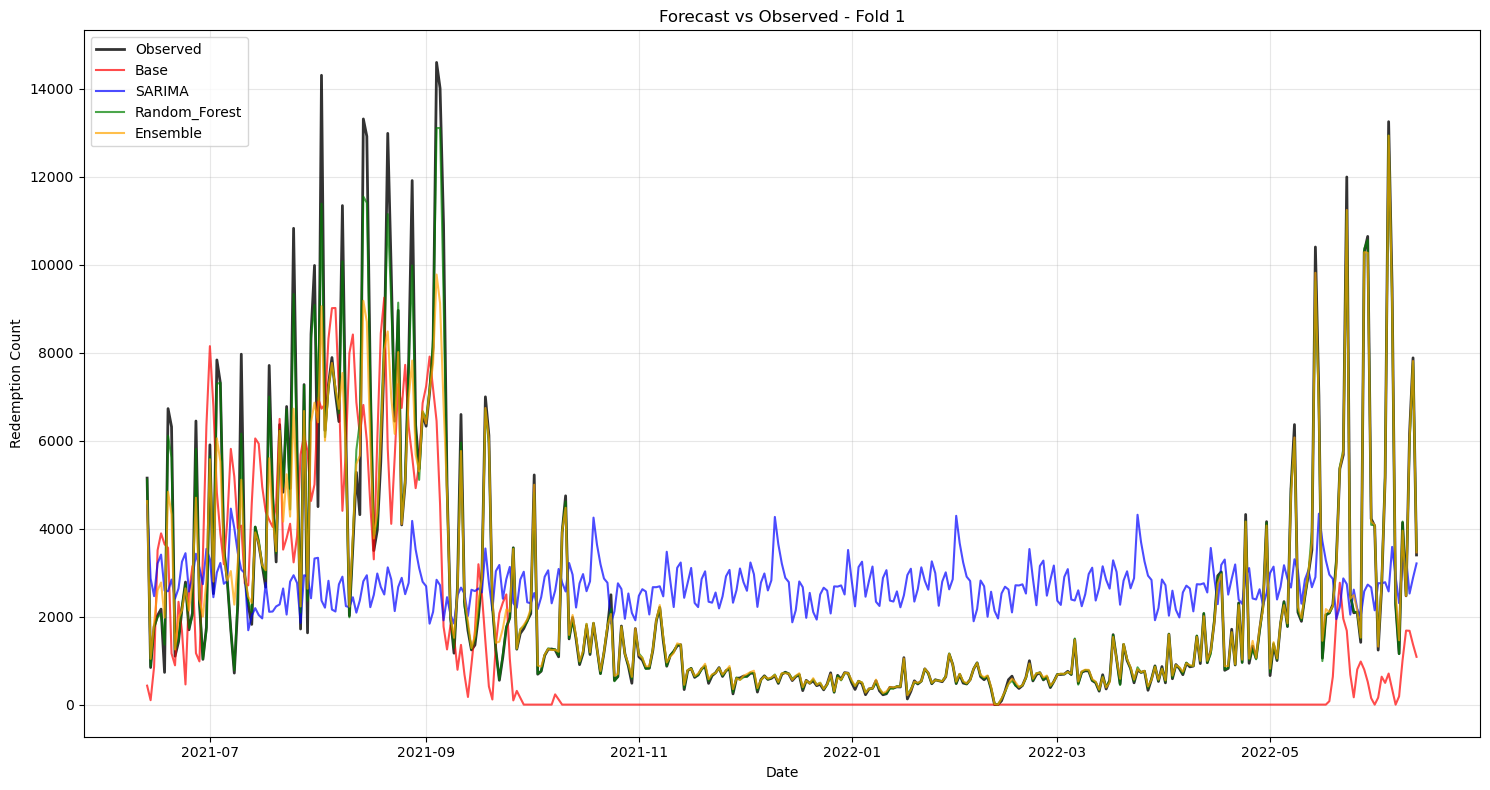

Training fold 2/4


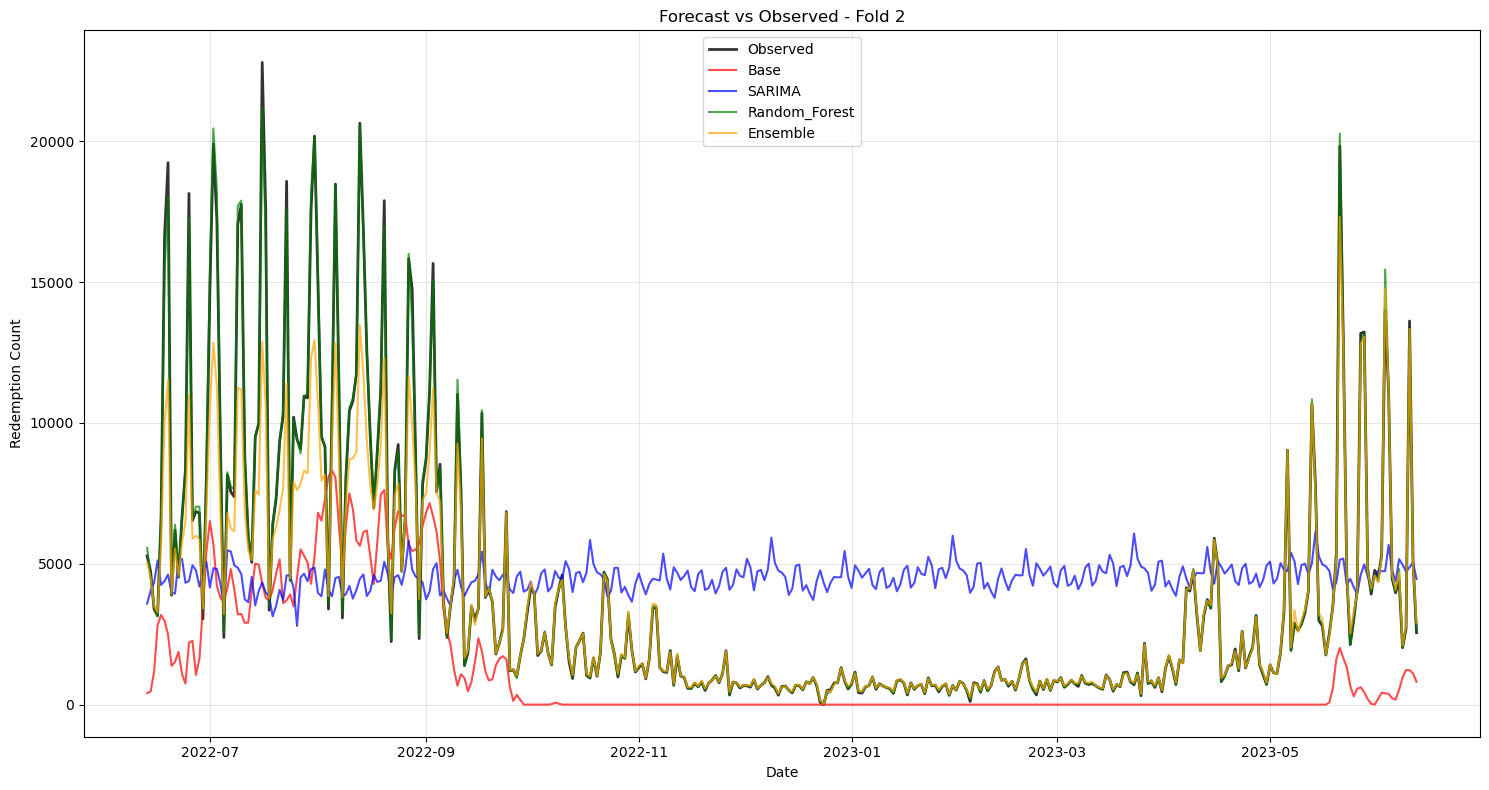

Training fold 3/4


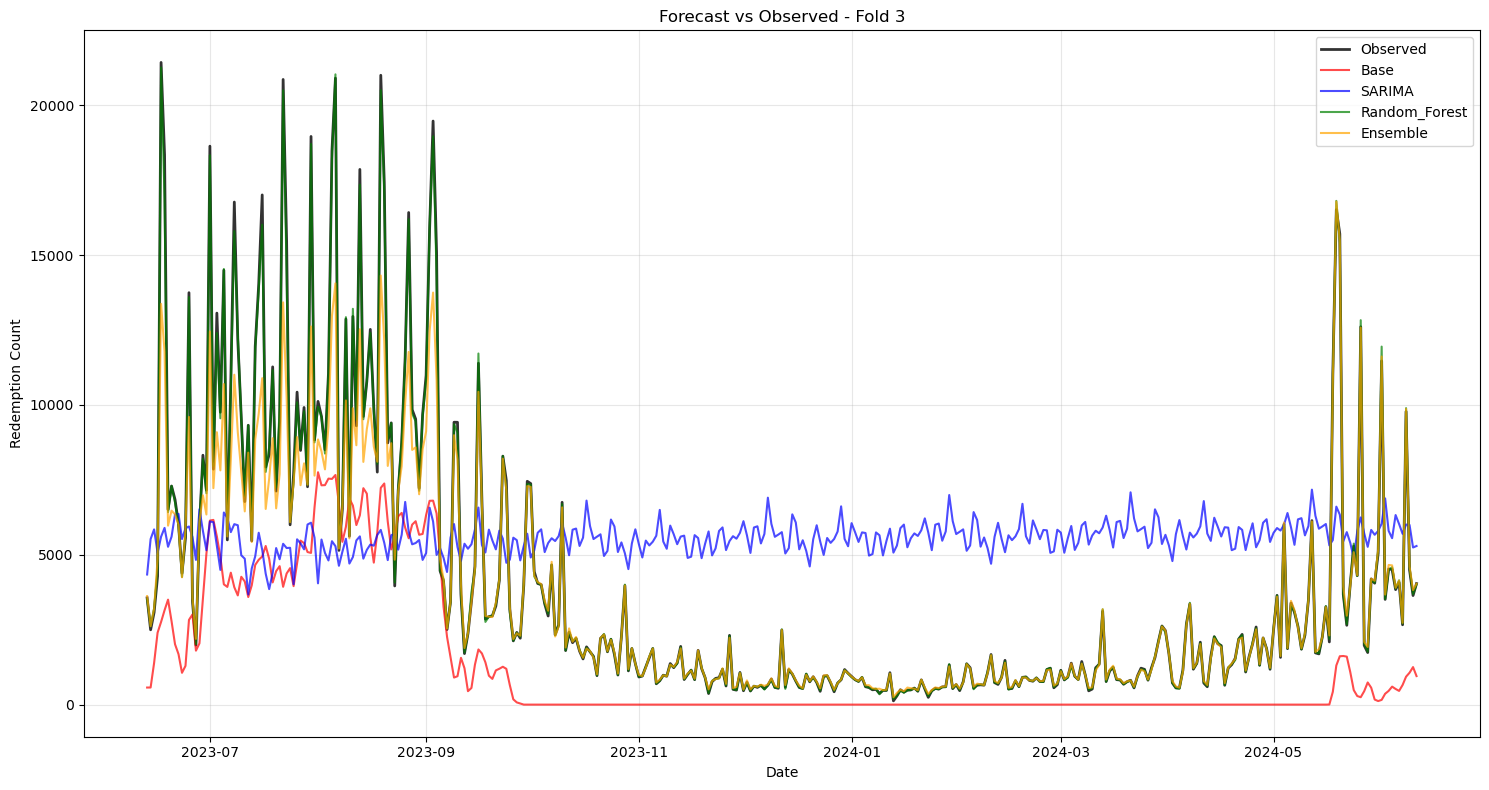

Training fold 4/4


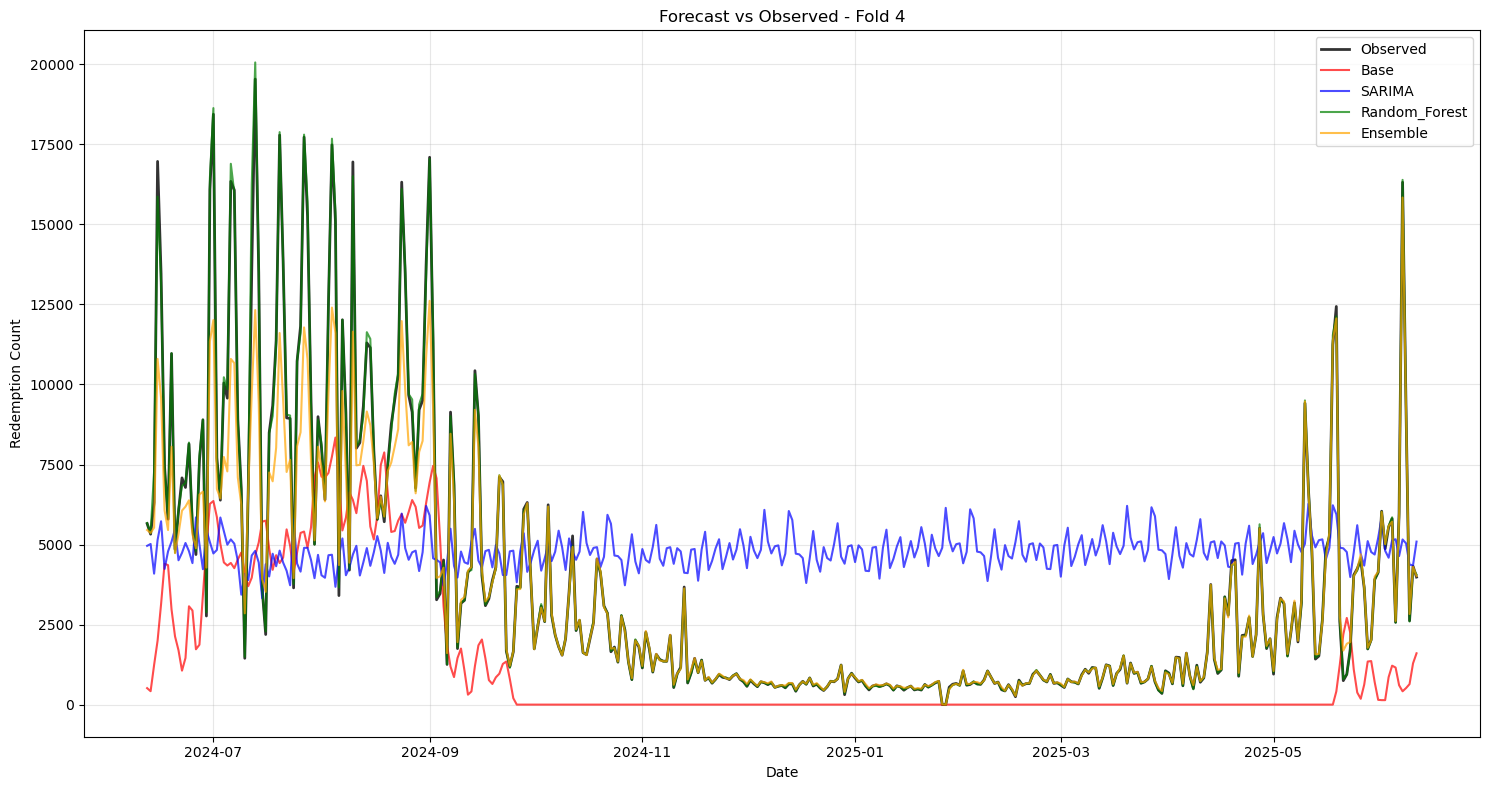

Model Results: {'Base': {0: 0.8917838081113705, 1: 0.8535856042944977, 2: 0.8495029583241723, 3: 0.8582048204199051}, 'SARIMA': {0: 5.046315777463052e+16, 1: 5.339154600405848e+16, 2: 3.535406211956515, 3: 1.362764315862222e+17}, 'Exponential_Smoothing': {0: 2.3173239617227178e+17, 1: 1.2029677516587722e+17, 2: 8.209540432178452, 3: 2.90456300806756e+17}, 'Random_Forest': {0: 322531765094424.06, 1: 443080171558560.25, 2: 0.019113130294754595, 3: 209016377226455.38}, 'Gradient_Boosting': {0: 0.07737483175768363, 1: 0.055956720165473615, 2: 0.05101954366111327, 3: 0.0401063180783434}, 'Ridge_Regression': {0: 0.09311799857229658, 1: 0.07498292281851715, 2: 0.0685331295710726, 3: 0.05986833111243979}, 'Ensemble': {0: 161265882547212.12, 1: 221540085779280.2, 2: 0.07200081451202292, 3: 104508188613227.75}}

Average Scores by Model:
Gradient_Boosting: 0.0561
Ridge_Regression: 0.0741
Base: 0.8633
Ensemble: 121828539234930.0312
Random_Forest: 243657078469859.9062
SARIMA: 60032783841227800.0000

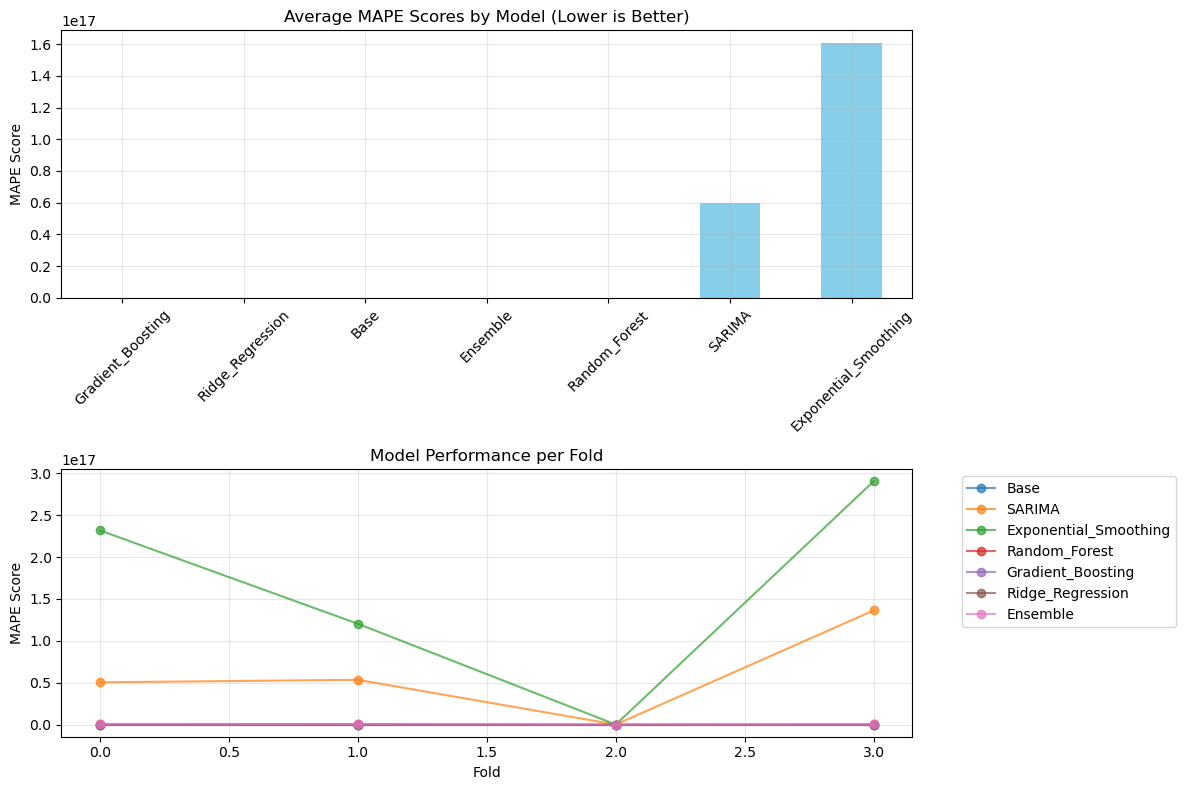


Best performing model: Gradient_Boosting (MAPE: 0.0561)
Improvement over base model: 93.5%


In [1]:
# This code defines a comprehensive time series forecasting class, ImprovedRedemptionModel, that uses a combination of statistical models (SARIMA, Exponential Smoothing), machine learning models (Random Forest, Gradient Boosting, Ridge Regression), and feature engineering techniques to predict a target variable over time. It includes automatic feature creation, model training with cross-validation, ensemble prediction, and performance evaluation using MAPE.

# Best
# Best
# Best
# Best
# Best
# Best


import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

class ImprovedRedemptionModel:
    def __init__(self, X, target_col):
        '''
        Args:
            X (pandas.DataFrame): Dataset of predictors, with DateTime index
            target_col (str): column name for target variable
        '''
        self._predictions = {}
        self.X = X
        self.target_col = target_col
        self.results = {}  # dict of dicts with model results
        self.scalers = {}  # Store scalers for each model
        
    def score(self, truth, preds):
        # Score our predictions using MAPE
        return MAPE(truth, preds)
    
    def create_features(self, df):
        '''Create comprehensive feature set for ML models'''
        df_features = df.copy()
        
        # Time-based features
        df_features['day_of_week'] = df_features.index.dayofweek
        df_features['day_of_month'] = df_features.index.day
        df_features['day_of_year'] = df_features.index.dayofyear
        df_features['week_of_year'] = df_features.index.isocalendar().week
        df_features['is_weekend'] = (df_features.index.dayofweek >= 5).astype(int)
        df_features['is_month_start'] = df_features.index.is_month_start.astype(int)
        df_features['is_month_end'] = df_features.index.is_month_end.astype(int)
        
        # Seasonal features using trigonometric functions
        df_features['sin_day_of_year'] = np.sin(2 * np.pi * df_features['day_of_year'] / 365.25)
        df_features['cos_day_of_year'] = np.cos(2 * np.pi * df_features['day_of_year'] / 365.25)
        df_features['sin_day_of_week'] = np.sin(2 * np.pi * df_features['day_of_week'] / 7)
        df_features['cos_day_of_week'] = np.cos(2 * np.pi * df_features['day_of_week'] / 7)
        
        # Lag features
        target_col = self.target_col
        for lag in [1, 7, 14, 30, 365]:
            df_features[f'{target_col}_lag_{lag}'] = df_features[target_col].shift(lag)
        
        # Rolling statistics
        for window in [7, 14, 30]:
            df_features[f'{target_col}_rolling_mean_{window}'] = df_features[target_col].rolling(window=window, min_periods=1).mean()
            df_features[f'{target_col}_rolling_std_{window}'] = df_features[target_col].rolling(window=window, min_periods=1).std()
            df_features[f'{target_col}_rolling_median_{window}'] = df_features[target_col].rolling(window=window, min_periods=1).median()
        
        # Exponential moving averages
        for alpha in [0.1, 0.3, 0.5]:
            df_features[f'{target_col}_ema_{alpha}'] = df_features[target_col].ewm(alpha=alpha, adjust=False).mean()
        
        # Sales ratio (if Sales Count exists)
        if 'Sales Count' in df_features.columns:
            df_features['redemption_sales_ratio'] = df_features[target_col] / (df_features['Sales Count'] + 1)
            # Lag features for sales
            for lag in [1, 7, 14]:
                df_features[f'Sales_Count_lag_{lag}'] = df_features['Sales Count'].shift(lag)
        
        return df_features
    
    def get_feature_columns(self, df):
        '''Get list of feature columns (excluding target and non-feature columns)'''
        exclude_cols = [self.target_col, '_id'] if '_id' in df.columns else [self.target_col]
        return [col for col in df.columns if col not in exclude_cols]
    
    def run_models(self, n_splits=4, test_size=365):
        '''Run multiple models and store results for cross validated splits'''
        # Create features first
        df_with_features = self.create_features(self.X)
        
        tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size)
        
        for fold_idx, (train_idx, test_idx) in enumerate(tscv.split(df_with_features)):
            print(f"Training fold {fold_idx + 1}/{n_splits}")
            
            X_train = df_with_features.iloc[train_idx]
            X_test = df_with_features.iloc[test_idx]
            
            # Base model (original)
            preds_base = self._base_model(X_train, X_test)
            self._store_result('Base', fold_idx, X_test[self.target_col], preds_base)
            
            # SARIMA model
            preds_sarima = self._sarima_model(X_train, X_test)
            self._store_result('SARIMA', fold_idx, X_test[self.target_col], preds_sarima)
            
            # Exponential Smoothing
            preds_exp_smooth = self._exponential_smoothing_model(X_train, X_test)
            self._store_result('Exponential_Smoothing', fold_idx, X_test[self.target_col], preds_exp_smooth)
            
            # Machine Learning models
            feature_cols = self.get_feature_columns(df_with_features)
            
            # Random Forest
            preds_rf = self._random_forest_model(X_train, X_test, feature_cols, fold_idx)
            self._store_result('Random_Forest', fold_idx, X_test[self.target_col], preds_rf)
            
            # Gradient Boosting
            preds_gb = self._gradient_boosting_model(X_train, X_test, feature_cols, fold_idx)
            self._store_result('Gradient_Boosting', fold_idx, X_test[self.target_col], preds_gb)
            
            # Linear Regression with regularization
            preds_ridge = self._ridge_model(X_train, X_test, feature_cols, fold_idx)
            self._store_result('Ridge_Regression', fold_idx, X_test[self.target_col], preds_ridge)
            
            # Ensemble model
            preds_ensemble = self._ensemble_model(
                [preds_base, preds_sarima, preds_exp_smooth, preds_rf, preds_gb, preds_ridge]
            )
            self._store_result('Ensemble', fold_idx, X_test[self.target_col], preds_ensemble)
            
            # Plot results for this fold
            self.plot_fold_results(X_test, fold_idx, {
                'Base': preds_base,
                'SARIMA': preds_sarima,
                'Random_Forest': preds_rf,
                'Ensemble': preds_ensemble
            })
    
    def _store_result(self, model_name, fold_idx, truth, preds):
        '''Store model results'''
        if model_name not in self.results:
            self.results[model_name] = {}
        self.results[model_name][fold_idx] = self.score(truth, preds)
    
    def _base_model(self, train, test):
        '''Original base model'''
        res = sm.tsa.seasonal_decompose(train[self.target_col], period=365)
        res_clip = res.seasonal.apply(lambda x: max(0, x))
        res_clip.index = res_clip.index.dayofyear
        res_clip = res_clip.groupby(res_clip.index).mean()
        res_dict = res_clip.to_dict()
        return pd.Series(index=test.index,
                         data=[res_dict.get(d, 0) for d in test.index.dayofyear])
    
    def _sarima_model(self, train, test):
        '''SARIMA model for time series forecasting'''
        try:
            # Fit SARIMA model
            model = sm.tsa.SARIMAX(train[self.target_col], 
                                 order=(1, 1, 1), 
                                 seasonal_order=(1, 1, 1, 52),  # Weekly seasonality
                                 enforce_stationarity=False,
                                 enforce_invertibility=False)
            fitted_model = model.fit(disp=False, maxiter=100)
            
            # Generate predictions
            forecast = fitted_model.forecast(steps=len(test))
            return pd.Series(index=test.index, data=np.maximum(forecast, 0))
        except:
            # Fallback to simple exponential smoothing if SARIMA fails
            return self._exponential_smoothing_model(train, test)
    
    def _exponential_smoothing_model(self, train, test):
        '''Exponential Smoothing model'''
        try:
            model = sm.tsa.ExponentialSmoothing(train[self.target_col], 
                                              trend='add', 
                                              seasonal='add', 
                                              seasonal_periods=52)
            fitted_model = model.fit(optimized=True, remove_bias=True)
            forecast = fitted_model.forecast(steps=len(test))
            return pd.Series(index=test.index, data=np.maximum(forecast, 0))
        except:
            # Simple fallback
            mean_val = train[self.target_col].mean()
            return pd.Series(index=test.index, data=[mean_val] * len(test))
    
    def _random_forest_model(self, train, test, feature_cols, fold_idx):
        '''Random Forest model'''
        # Remove rows with NaN values
        train_clean = train.dropna()
        test_clean = test.dropna()
        
        if len(train_clean) == 0 or len(test_clean) == 0:
            return pd.Series(index=test.index, data=[train[self.target_col].mean()] * len(test))
        
        X_train = train_clean[feature_cols]
        y_train = train_clean[self.target_col]
        X_test = test_clean[feature_cols]
        
        model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
        model.fit(X_train, y_train)
        
        preds = model.predict(X_test)
        
        # Create full prediction series
        full_preds = pd.Series(index=test.index, data=train[self.target_col].mean())
        full_preds.loc[test_clean.index] = np.maximum(preds, 0)
        
        return full_preds
    
    def _gradient_boosting_model(self, train, test, feature_cols, fold_idx):
        '''Gradient Boosting model'''
        train_clean = train.dropna()
        test_clean = test.dropna()
        
        if len(train_clean) == 0 or len(test_clean) == 0:
            return pd.Series(index=test.index, data=[train[self.target_col].mean()] * len(test))
        
        X_train = train_clean[feature_cols]
        y_train = train_clean[self.target_col]
        X_test = test_clean[feature_cols]
        
        model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
        model.fit(X_train, y_train)
        
        preds = model.predict(X_test)
        
        full_preds = pd.Series(index=test.index, data=train[self.target_col].mean())
        full_preds.loc[test_clean.index] = np.maximum(preds, 0)
        
        return full_preds
    
    def _ridge_model(self, train, test, feature_cols, fold_idx):
        '''Ridge Regression model with scaling'''
        train_clean = train.dropna()
        test_clean = test.dropna()
        
        if len(train_clean) == 0 or len(test_clean) == 0:
            return pd.Series(index=test.index, data=[train[self.target_col].mean()] * len(test))
        
        X_train = train_clean[feature_cols]
        y_train = train_clean[self.target_col]
        X_test = test_clean[feature_cols]
        
        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        model = Ridge(alpha=1.0, random_state=42)
        model.fit(X_train_scaled, y_train)
        
        preds = model.predict(X_test_scaled)
        
        full_preds = pd.Series(index=test.index, data=train[self.target_col].mean())
        full_preds.loc[test_clean.index] = np.maximum(preds, 0)
        
        return full_preds
    
    def _ensemble_model(self, predictions_list):
        '''Simple ensemble using median of predictions'''
        # Stack predictions and take median
        stacked = np.column_stack([pred.values for pred in predictions_list])
        ensemble_preds = np.median(stacked, axis=1)
        return pd.Series(index=predictions_list[0].index, data=ensemble_preds)
    
    def plot_fold_results(self, test_data, fold_idx, predictions_dict):
        '''Plot results for a specific fold'''
        fig, ax = plt.subplots(figsize=(15, 8))
        
        # Plot observed values
        ax.plot(test_data.index, test_data[self.target_col], 
               label='Observed', color='black', linewidth=2, alpha=0.8)
        
        # Plot predictions
        colors = ['red', 'blue', 'green', 'orange', 'purple']
        for i, (model_name, preds) in enumerate(predictions_dict.items()):
            ax.plot(preds.index, preds.values, 
                   label=f'{model_name}', color=colors[i % len(colors)], alpha=0.7)
        
        ax.set_title(f"Forecast vs Observed - Fold {fold_idx + 1}")
        ax.set_xlabel("Date")
        ax.set_ylabel("Redemption Count")
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    def plot_model_comparison(self):
        '''Plot comparison of all models'''
        df_results = pd.DataFrame(self.results)
        
        # Average scores
        avg_scores = df_results.mean().sort_values()
        
        plt.figure(figsize=(12, 8))
        plt.subplot(2, 1, 1)
        avg_scores.plot(kind='bar', color='skyblue')
        plt.title("Average MAPE Scores by Model (Lower is Better)")
        plt.ylabel("MAPE Score")
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        
        # Performance per fold
        plt.subplot(2, 1, 2)
        for column in df_results.columns:
            plt.plot(df_results.index, df_results[column], marker='o', label=column, alpha=0.7)
        
        plt.title("Model Performance per Fold")
        plt.xlabel("Fold")
        plt.ylabel("MAPE Score")
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        return avg_scores

def load_data(file_path):
    '''
    Load data from CSV, parse dates, resample to daily sums, and add monthly & quarterly features.
    '''
    df = pd.read_csv(file_path,
                     dtype={'_id': int, 'Redemption Count': int, 'Sales Count': int},
                     parse_dates=['Timestamp'])
    df.sort_values('Timestamp', inplace=True)
    df.set_index('Timestamp', inplace=True)
    df_daily = df.resample('D').sum()
    df_daily['monthly'] = df_daily.index.month
    df_daily['quarter'] = df_daily.index.quarter
    return df_daily

if __name__ == "__main__":
    # Set the path to your data file here
    data_file = r'C:\ALL\Jobs\Other\Maged Eid - Applied Scientist in Data Science (SX2)\Toronto Island Ferry Ticket Counts.csv'
    
    # Load data
    df = load_data(data_file)
    
    # Initialize and run improved model
    irm = ImprovedRedemptionModel(df, target_col='Redemption Count')
    irm.run_models()
    
    # Print model results
    print("Model Results:", irm.results)
    
    # Convert results to DataFrame and print averages
    df_results = pd.DataFrame(irm.results)
    print("\nAverage Scores by Model:")
    avg_scores = df_results.mean().sort_values()
    for model, score in avg_scores.items():
        print(f"{model}: {score:.4f}")
    
    # Plot comprehensive comparison
    best_scores = irm.plot_model_comparison()
    
    print(f"\nBest performing model: {best_scores.index[0]} (MAPE: {best_scores.iloc[0]:.4f})")
    print(f"Improvement over base model: {((avg_scores['Base'] - best_scores.iloc[0]) / avg_scores['Base'] * 100):.1f}%")

Loading data...
Initializing Fast Redemption Model...
Running models (target: <10 minutes per fold)...
Creating features...
Training fold 1/4
  - Running Base model...
  - Running Improved Seasonal model...
  - Running Exponential Smoothing...
  - Running Fast Random Forest...
  - Running Ridge Regression...
  - Creating Ensemble...
  Fold 1 completed in 0.0 minutes


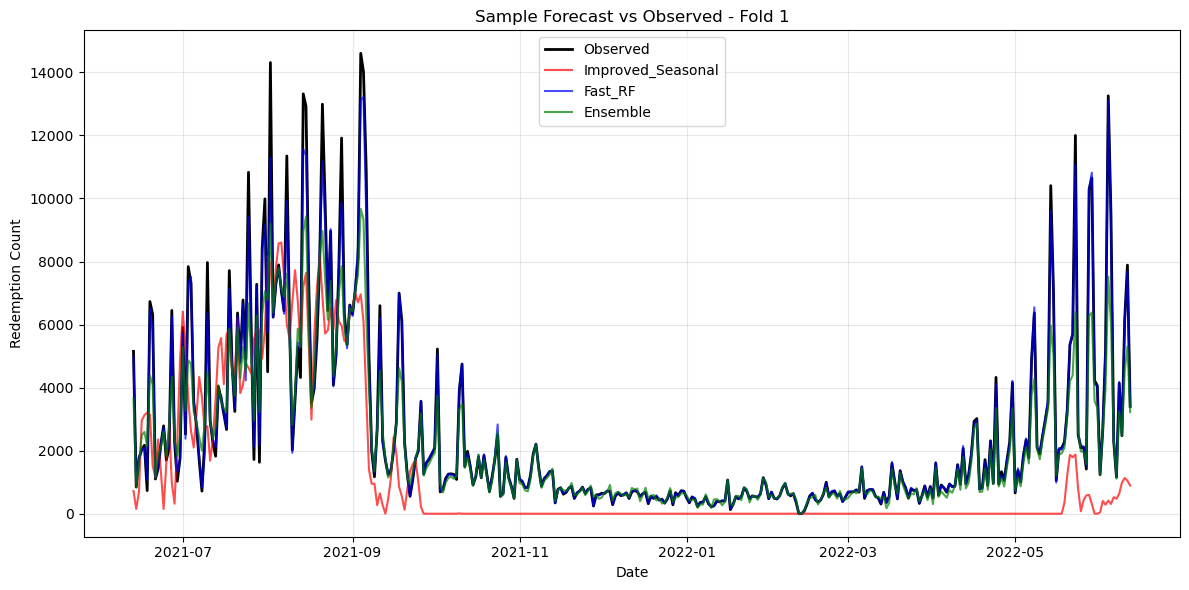

Training fold 2/4
  - Running Base model...
  - Running Improved Seasonal model...
  - Running Exponential Smoothing...
  - Running Fast Random Forest...
  - Running Ridge Regression...
  - Creating Ensemble...
  Fold 2 completed in 0.0 minutes
Training fold 3/4
  - Running Base model...
  - Running Improved Seasonal model...
  - Running Exponential Smoothing...
  - Running Fast Random Forest...
  - Running Ridge Regression...
  - Creating Ensemble...
  Fold 3 completed in 0.0 minutes
Training fold 4/4
  - Running Base model...
  - Running Improved Seasonal model...
  - Running Exponential Smoothing...
  - Running Fast Random Forest...
  - Running Ridge Regression...
  - Creating Ensemble...
  Fold 4 completed in 0.0 minutes

Total training time: 0.1 minutes
Model Results: {'Base': {0: 0.8917838081113705, 1: 0.8535856042944977, 2: 0.8495029583241723, 3: 0.8582048204199051}, 'Improved_Seasonal': {0: 0.86274612770279, 1: 3.6594073614598e+16, 2: 2.6761371411651407, 3: 1.0456278343123896e+

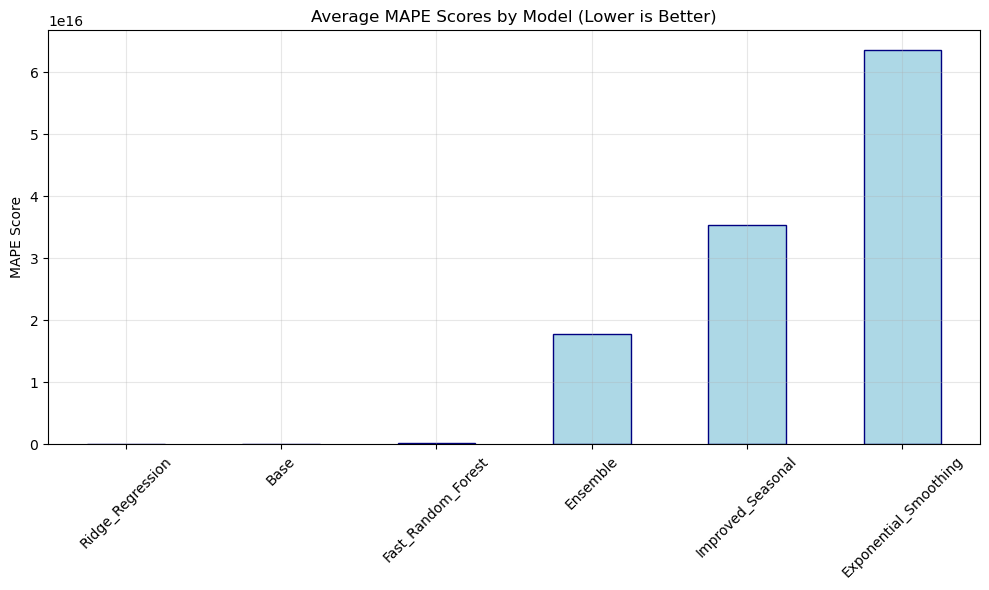


Best performing model: Ridge_Regression (MAPE: 0.1953)
Improvement over base model: 77.4%


In [5]:
# This code defines a class FastRedemptionModel that builds and evaluates multiple fast time-series forecasting models (e.g., seasonal decomposition, exponential smoothing, random forest, ridge regression) to predict a target variable over time using minimal yet effective features. It employs cross-validation with time splits and uses MAPE for model evaluation.



import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

class FastRedemptionModel:
    def __init__(self, X, target_col):
        '''
        Args:
            X (pandas.DataFrame): Dataset of predictors, with DateTime index
            target_col (str): column name for target variable
        '''
        self._predictions = {}
        self.X = X
        self.target_col = target_col
        self.results = {}  # dict of dicts with model results
        
    def score(self, truth, preds):
        # Score our predictions using MAPE
        return MAPE(truth, preds)
    
    def create_lean_features(self, df):
        '''Create essential features only - optimized for speed'''
        df_features = df.copy()
        
        # Core time features
        df_features['day_of_week'] = df_features.index.dayofweek
        df_features['day_of_year'] = df_features.index.dayofyear
        df_features['month'] = df_features.index.month
        df_features['is_weekend'] = (df_features.index.dayofweek >= 5).astype(int)
        
        # Essential seasonal features
        df_features['sin_day_of_year'] = np.sin(2 * np.pi * df_features['day_of_year'] / 365.25)
        df_features['cos_day_of_year'] = np.cos(2 * np.pi * df_features['day_of_year'] / 365.25)
        
        # Key lag features only
        target_col = self.target_col
        for lag in [1, 7, 30]:  # Reduced from [1, 7, 14, 30, 365]
            df_features[f'{target_col}_lag_{lag}'] = df_features[target_col].shift(lag)
        
        # Essential rolling features
        df_features[f'{target_col}_ma_7'] = df_features[target_col].rolling(window=7, min_periods=1).mean()
        df_features[f'{target_col}_ma_30'] = df_features[target_col].rolling(window=30, min_periods=1).mean()
        
        # Sales ratio if available
        if 'Sales Count' in df_features.columns:
            df_features['redemption_sales_ratio'] = df_features[target_col] / (df_features['Sales Count'] + 1)
        
        return df_features
    
    def get_feature_columns(self, df):
        '''Get list of feature columns (excluding target and non-feature columns)'''
        exclude_cols = [self.target_col, '_id'] if '_id' in df.columns else [self.target_col]
        return [col for col in df.columns if col not in exclude_cols]
    
    def run_models(self, n_splits=4, test_size=365):
        '''Run optimized models - should complete each fold in under 10 minutes'''
        print("Creating features...")
        df_with_features = self.create_lean_features(self.X)
        
        tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size)
        
        for fold_idx, (train_idx, test_idx) in enumerate(tscv.split(df_with_features)):
            print(f"Training fold {fold_idx + 1}/{n_splits}")
            fold_start_time = pd.Timestamp.now()
            
            X_train = df_with_features.iloc[train_idx]
            X_test = df_with_features.iloc[test_idx]
            
            # Base model (original) - Fast
            print("  - Running Base model...")
            preds_base = self._base_model(X_train, X_test)
            self._store_result('Base', fold_idx, X_test[self.target_col], preds_base)
            
            # Improved seasonal model - Fast
            print("  - Running Improved Seasonal model...")
            preds_seasonal = self._improved_seasonal_model(X_train, X_test)
            self._store_result('Improved_Seasonal', fold_idx, X_test[self.target_col], preds_seasonal)
            
            # Simple exponential smoothing - Fast
            print("  - Running Exponential Smoothing...")
            preds_exp = self._simple_exponential_smoothing(X_train, X_test)
            self._store_result('Exponential_Smoothing', fold_idx, X_test[self.target_col], preds_exp)
            
            # Fast Random Forest - Optimized
            print("  - Running Fast Random Forest...")
            feature_cols = self.get_feature_columns(df_with_features)
            preds_rf = self._fast_random_forest(X_train, X_test, feature_cols)
            self._store_result('Fast_Random_Forest', fold_idx, X_test[self.target_col], preds_rf)
            
            # Fast Ridge Regression - Very fast
            print("  - Running Ridge Regression...")
            preds_ridge = self._fast_ridge_model(X_train, X_test, feature_cols)
            self._store_result('Ridge_Regression', fold_idx, X_test[self.target_col], preds_ridge)
            
            # Simple ensemble - Fast
            print("  - Creating Ensemble...")
            preds_ensemble = self._simple_ensemble([preds_seasonal, preds_exp, preds_rf, preds_ridge])
            self._store_result('Ensemble', fold_idx, X_test[self.target_col], preds_ensemble)
            
            fold_time = (pd.Timestamp.now() - fold_start_time).total_seconds() / 60
            print(f"  Fold {fold_idx + 1} completed in {fold_time:.1f} minutes")
            
            # Quick plot for best models only
            if fold_idx == 0:  # Only plot first fold to save time
                self.plot_fold_results(X_test, fold_idx, {
                    'Observed': X_test[self.target_col],
                    'Improved_Seasonal': preds_seasonal,
                    'Fast_RF': preds_rf,
                    'Ensemble': preds_ensemble
                })
    
    def _store_result(self, model_name, fold_idx, truth, preds):
        '''Store model results'''
        if model_name not in self.results:
            self.results[model_name] = {}
        self.results[model_name][fold_idx] = self.score(truth, preds)
    
    def _base_model(self, train, test):
        '''Original base model'''
        try:
            res = sm.tsa.seasonal_decompose(train[self.target_col], period=365)
            res_clip = res.seasonal.apply(lambda x: max(0, x))
            res_clip.index = res_clip.index.dayofyear
            res_clip = res_clip.groupby(res_clip.index).mean()
            res_dict = res_clip.to_dict()
            return pd.Series(index=test.index,
                           data=[res_dict.get(d, 0) for d in test.index.dayofyear])
        except:
            mean_val = train[self.target_col].mean()
            return pd.Series(index=test.index, data=[mean_val] * len(test))
    
    def _improved_seasonal_model(self, train, test):
        '''Improved seasonal model with trend and better handling'''
        try:
            # Use shorter period for faster computation
            period = min(365, len(train) // 3)
            if period < 7:
                period = 7
                
            decomp = sm.tsa.seasonal_decompose(train[self.target_col], 
                                             period=period, 
                                             extrapolate_trend='freq')
            
            # Extract components
            trend = decomp.trend.fillna(method='bfill').fillna(method='ffill')
            seasonal = decomp.seasonal
            
            # Create day-of-year mapping for seasonal component
            seasonal_clean = seasonal.apply(lambda x: max(0, x))
            
            if period <= 365:
                seasonal_clean.index = seasonal_clean.index.dayofyear
                seasonal_dict = seasonal_clean.groupby(seasonal_clean.index).mean().to_dict()
            else:
                # For longer periods, use modulo
                seasonal_clean.index = seasonal_clean.index % period
                seasonal_dict = seasonal_clean.groupby(seasonal_clean.index).mean().to_dict()
            
            # Use last trend value for forecast
            last_trend = trend.iloc[-1] if not pd.isna(trend.iloc[-1]) else train[self.target_col].mean()
            
            # Generate predictions
            if period <= 365:
                seasonal_preds = [seasonal_dict.get(d, 0) for d in test.index.dayofyear]
            else:
                seasonal_preds = [seasonal_dict.get(i % period, 0) for i in range(len(test))]
            
            final_preds = [max(0, last_trend + s) for s in seasonal_preds]
            
            return pd.Series(index=test.index, data=final_preds)
        except Exception as e:
            print(f"    Improved seasonal failed: {e}, using fallback")
            return self._base_model(train, test)
    
    def _simple_exponential_smoothing(self, train, test):
        '''Simple exponential smoothing - very fast'''
        try:
            # Simple exponential smoothing without seasonal
            model = sm.tsa.SimpleExpSmoothing(train[self.target_col])
            fitted_model = model.fit(optimized=True)
            forecast = fitted_model.forecast(steps=len(test))
            return pd.Series(index=test.index, data=np.maximum(forecast, 0))
        except:
            # Even simpler fallback
            alpha = 0.3
            last_val = train[self.target_col].iloc[-1]
            return pd.Series(index=test.index, data=[max(0, last_val)] * len(test))
    
    def _fast_random_forest(self, train, test, feature_cols):
        '''Optimized Random Forest - fewer trees, simpler features'''
        try:
            # Clean data
            train_clean = train.dropna()
            if len(train_clean) < 10:  # Not enough data
                return pd.Series(index=test.index, data=[train[self.target_col].mean()] * len(test))
            
            X_train = train_clean[feature_cols]
            y_train = train_clean[self.target_col]
            
            # Fast Random Forest with fewer trees
            model = RandomForestRegressor(
                n_estimators=50,  # Reduced from 100
                max_depth=10,     # Limit depth
                min_samples_split=5,
                min_samples_leaf=2,
                random_state=42,
                n_jobs=-1  # Use all cores
            )
            model.fit(X_train, y_train)
            
            # Make predictions
            test_clean = test.dropna()
            if len(test_clean) == 0:
                return pd.Series(index=test.index, data=[train[self.target_col].mean()] * len(test))
            
            X_test = test_clean[feature_cols]
            preds = model.predict(X_test)
            
            # Fill full prediction series
            full_preds = pd.Series(index=test.index, data=train[self.target_col].mean())
            full_preds.loc[test_clean.index] = np.maximum(preds, 0)
            
            return full_preds
        except Exception as e:
            print(f"    Random Forest failed: {e}, using mean")
            return pd.Series(index=test.index, data=[train[self.target_col].mean()] * len(test))
    
    def _fast_ridge_model(self, train, test, feature_cols):
        '''Fast Ridge Regression'''
        try:
            train_clean = train.dropna()
            if len(train_clean) < 10:
                return pd.Series(index=test.index, data=[train[self.target_col].mean()] * len(test))
            
            X_train = train_clean[feature_cols]
            y_train = train_clean[self.target_col]
            
            # Quick scaling and modeling
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            
            model = Ridge(alpha=1.0, random_state=42)
            model.fit(X_train_scaled, y_train)
            
            # Predict
            test_clean = test.dropna()
            if len(test_clean) == 0:
                return pd.Series(index=test.index, data=[train[self.target_col].mean()] * len(test))
            
            X_test = test_clean[feature_cols]
            X_test_scaled = scaler.transform(X_test)
            preds = model.predict(X_test_scaled)
            
            full_preds = pd.Series(index=test.index, data=train[self.target_col].mean())
            full_preds.loc[test_clean.index] = np.maximum(preds, 0)
            
            return full_preds
        except Exception as e:
            print(f"    Ridge failed: {e}, using mean")
            return pd.Series(index=test.index, data=[train[self.target_col].mean()] * len(test))
    
    def _simple_ensemble(self, predictions_list):
        '''Simple ensemble using median - very fast'''
        try:
            # Stack predictions and take median
            stacked = np.column_stack([pred.values for pred in predictions_list])
            ensemble_preds = np.median(stacked, axis=1)
            return pd.Series(index=predictions_list[0].index, data=ensemble_preds)
        except:
            # Fallback to first prediction
            return predictions_list[0]
    
    def plot_fold_results(self, test_data, fold_idx, predictions_dict):
        '''Quick plot for first fold only'''
        fig, ax = plt.subplots(figsize=(12, 6))
        
        # Plot observed values
        observed = predictions_dict.pop('Observed')
        ax.plot(observed.index, observed.values, 
               label='Observed', color='black', linewidth=2)
        
        # Plot top predictions
        colors = ['red', 'blue', 'green']
        for i, (model_name, preds) in enumerate(predictions_dict.items()):
            ax.plot(preds.index, preds.values, 
                   label=f'{model_name}', color=colors[i % len(colors)], alpha=0.7)
        
        ax.set_title(f"Sample Forecast vs Observed - Fold {fold_idx + 1}")
        ax.set_xlabel("Date")
        ax.set_ylabel("Redemption Count")
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    def plot_final_comparison(self):
        '''Plot final model comparison'''
        df_results = pd.DataFrame(self.results)
        
        # Average scores
        avg_scores = df_results.mean().sort_values()
        
        plt.figure(figsize=(10, 6))
        avg_scores.plot(kind='bar', color='lightblue', edgecolor='navy')
        plt.title("Average MAPE Scores by Model (Lower is Better)")
        plt.ylabel("MAPE Score")
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        return avg_scores

def load_data(file_path):
    '''Load data from CSV, parse dates, resample to daily sums, and add monthly & quarterly features.'''
    df = pd.read_csv(file_path,
                     dtype={'_id': int, 'Redemption Count': int, 'Sales Count': int},
                     parse_dates=['Timestamp'])
    df.sort_values('Timestamp', inplace=True)
    df.set_index('Timestamp', inplace=True)
    df_daily = df.resample('D').sum()
    df_daily['monthly'] = df_daily.index.month
    df_daily['quarter'] = df_daily.index.quarter
    return df_daily

if __name__ == "__main__":
    # Set the path to your data file here
    data_file = r'C:\ALL\Jobs\Other\Maged Eid - Applied Scientist in Data Science (SX2)\Toronto Island Ferry Ticket Counts.csv'
    
    print("Loading data...")
    df = load_data(data_file)
    
    print("Initializing Fast Redemption Model...")
    frm = FastRedemptionModel(df, target_col='Redemption Count')
    
    print("Running models (target: <10 minutes per fold)...")
    start_time = pd.Timestamp.now()
    frm.run_models()
    total_time = (pd.Timestamp.now() - start_time).total_seconds() / 60
    
    print(f"\nTotal training time: {total_time:.1f} minutes")
    print("Model Results:", frm.results)
    
    # Show results
    df_results = pd.DataFrame(frm.results)
    print("\nAverage Scores by Model:")
    avg_scores = df_results.mean().sort_values()
    for model, score in avg_scores.items():
        print(f"{model}: {score:.4f}")
    
    # Plot comparison
    best_scores = frm.plot_final_comparison()
    
    print(f"\nBest performing model: {best_scores.index[0]} (MAPE: {best_scores.iloc[0]:.4f})")
    if 'Base' in avg_scores:
        improvement = ((avg_scores['Base'] - best_scores.iloc[0]) / avg_scores['Base'] * 100)
        print(f"Improvement over base model: {improvement:.1f}%")

In [ ]:
# Sales Forecasting Model
# Sales Forecasting Model
# Sales Forecasting Model
# Sales Forecasting Model
# Sales Forecasting Model
# Sales Forecasting Model
# Sales Forecasting Model
# Sales Forecasting Model
# Sales Forecasting Model
# Sales Forecasting Model

Libraries imported successfully!
Dataset Info:
Shape: (246818, 4)
Columns: ['_id', 'Timestamp', 'Redemption Count', 'Sales Count']

First 5 rows:
   _id            Timestamp  Redemption Count  Sales Count
0    1  2025-06-11T14:45:00               212          199
1    2  2025-06-11T14:30:00               204          206
2    3  2025-06-11T14:15:00               211          165
3    4  2025-06-11T14:00:00               179          270
4    5  2025-06-11T13:45:00                98          150

Dataset Description:
                 _id  Redemption Count    Sales Count
count  246818.000000     246818.000000  246818.000000
mean   123409.500000         46.889331      47.652189
std     71250.363708        101.723647      97.587637
min         1.000000          0.000000       0.000000
25%     61705.250000          3.000000       3.000000
50%    123409.500000         10.000000      12.000000
75%    185113.750000         38.000000      46.000000
max    246818.000000       7216.000000    7229

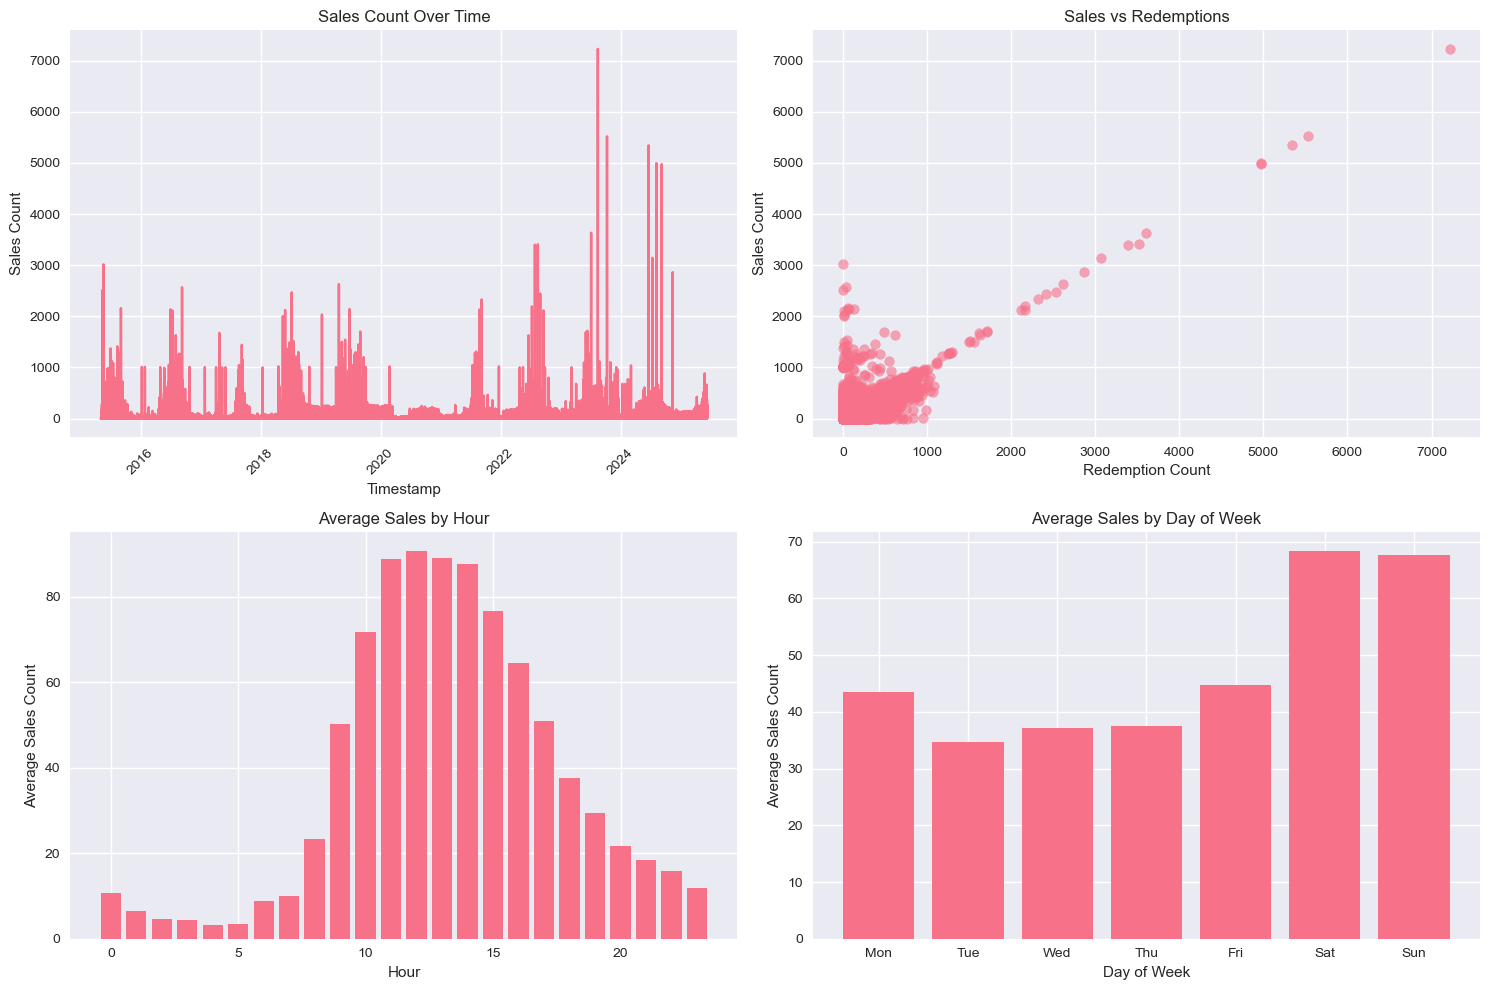

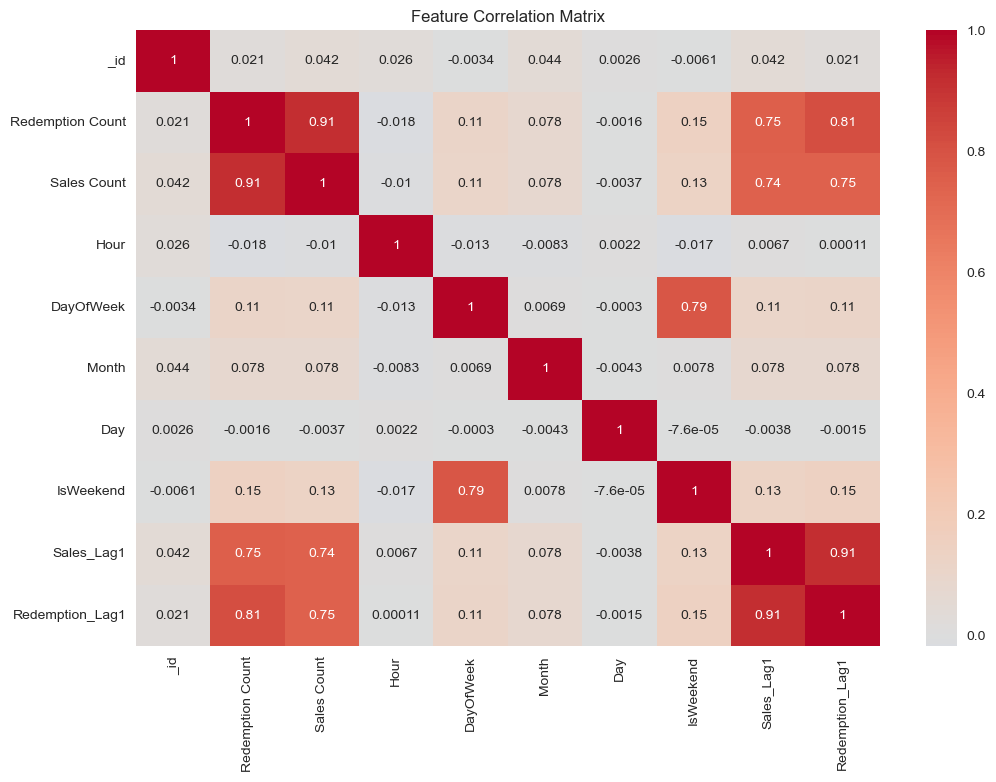

SalesModel class defined successfully!
Running Time Series Cross-Validation...
Fold  1: R² = 0.8378, MAPE = 859822883459.72%, MAE =  15.56, RMSE =  41.52
Fold  2: R² = 0.8081, MAPE = 1173303580948.43%, MAE =  12.72, RMSE =  35.71
Fold  3: R² = 0.7304, MAPE = 687410368459.48%, MAE =  11.62, RMSE =  24.03
Fold  4: R² = 0.9007, MAPE = 321561359246.37%, MAE =  15.37, RMSE =  36.29
Fold  5: R² = 0.9197, MAPE = 533154291985.23%, MAE =  11.46, RMSE =  24.97

SALES FORECASTING MODEL RESULTS SUMMARY
Average R² Score:  0.8394 (±0.0679)
Average MAPE:      715050496819.84% (±289702896245.13%)
Average MAE:        13.35 (±  1.78)
Average RMSE:       32.50 (±  6.85)
Best R² Score:     0.9197
Best MAPE:         321561359246.37%

Feature Importance Analysis:
            Feature  Coefficient  Abs_Coefficient
5         IsWeekend    -2.033098         2.033098
0  Redemption Count     0.853744         0.853744
2         DayOfWeek     0.479209         0.479209
6        Sales_Lag1     0.311636         0.31163

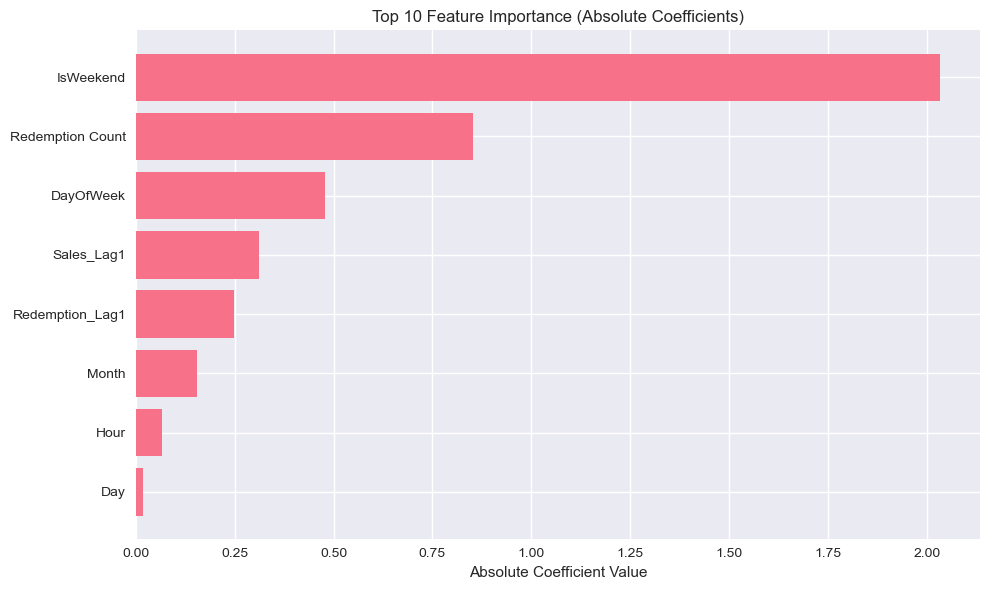

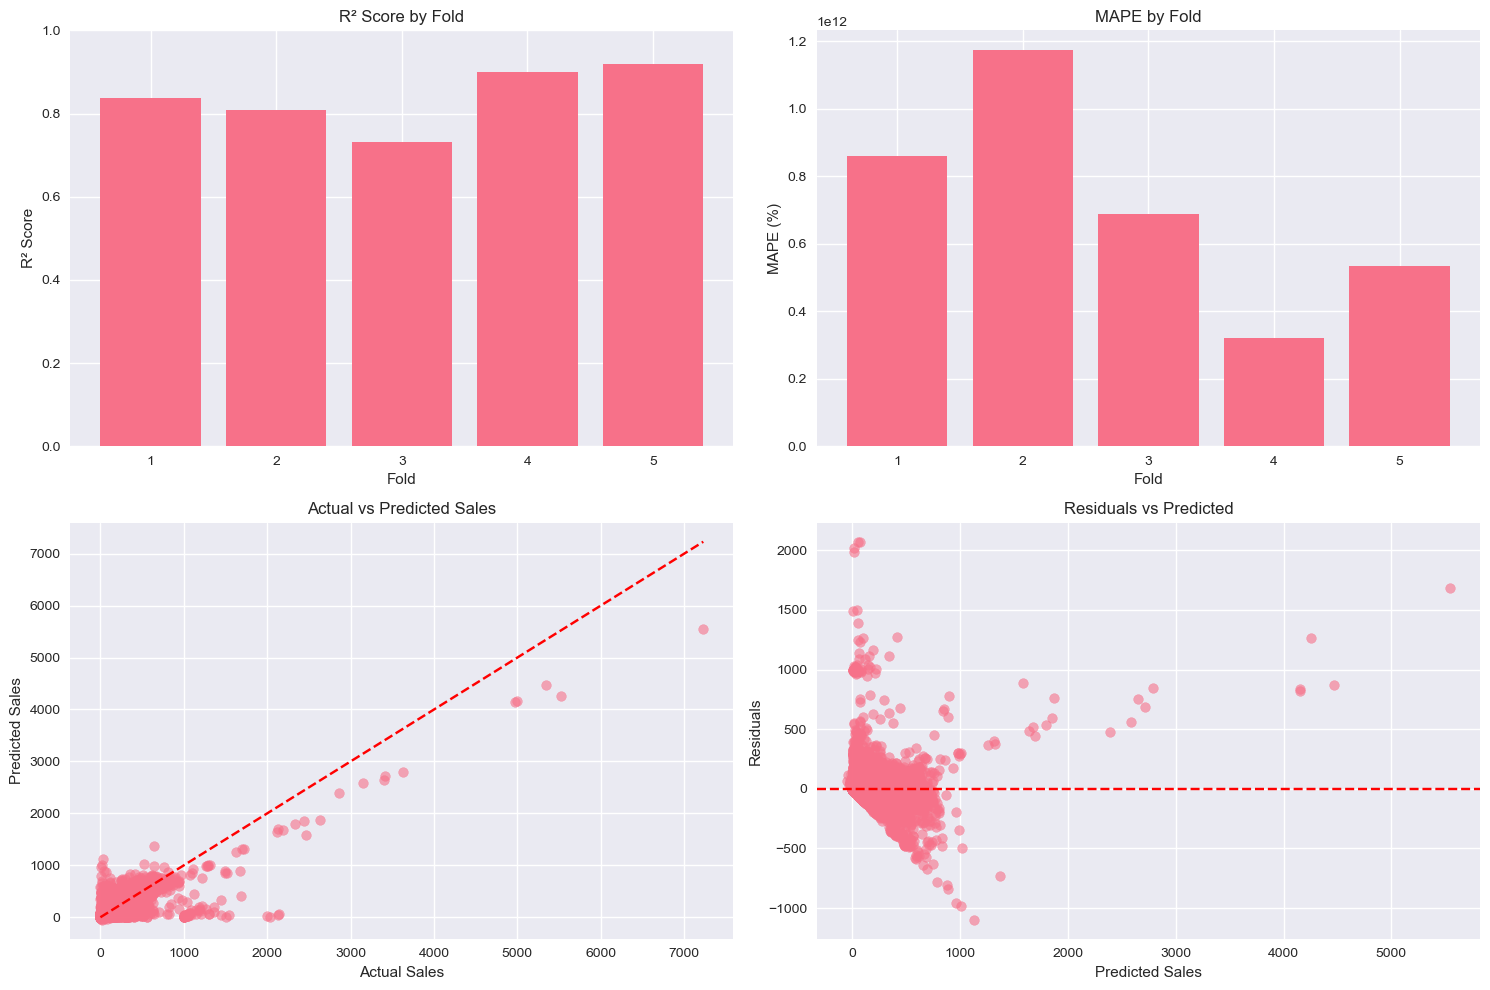


FINAL MODEL PERFORMANCE SUMMARY
R2          :   0.8394 ±   0.0679
MAPE        : 715050496819.84% ± 289702896245.13%
MAE         :  13.3455 ±   1.7834
RMSE        :  32.5022 ±   6.8478

Interpretation:
----------------------------------------
R² Score Quality: Excellent (0.8394)
MAPE Quality: Poor (715050496819.84%)

Model training and evaluation completed!
You can now use the trained model for future predictions.


In [7]:
# Sales Forecasting Model

# This code builds a sales forecasting model using Toronto Island Ferry ticket data. It performs data preprocessing, feature engineering, exploratory analysis, and trains a linear regression model with time-series cross-validation, evaluating performance using metrics like R², MAPE, MAE, and RMSE, and visualizes the results and feature importance.


# Cell 1: Import Libraries and Load Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")

# Cell 2: Load and Explore Data
# Load the Toronto Island Ferry data
file_path = r"C:\ALL\Jobs\Other\Maged Eid - Applied Scientist in Data Science (SX2)\Toronto Island Ferry Ticket Counts.csv"
df = pd.read_csv(file_path)

print("Dataset Info:")
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print("\nFirst 5 rows:")
print(df.head())

print("\nDataset Description:")
print(df.describe())

print("\nMissing Values:")
print(df.isnull().sum())

# Cell 3: Data Preprocessing
# Convert Timestamp to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Create time-based features
df['Hour'] = df['Timestamp'].dt.hour
df['DayOfWeek'] = df['Timestamp'].dt.dayofweek
df['Month'] = df['Timestamp'].dt.month
df['Day'] = df['Timestamp'].dt.day
df['IsWeekend'] = (df['DayOfWeek'] >= 5).astype(int)

# Create lag features (previous period values)
df = df.sort_values('Timestamp')
df['Sales_Lag1'] = df['Sales Count'].shift(1)
df['Redemption_Lag1'] = df['Redemption Count'].shift(1)

# Drop rows with NaN values created by lag features
df = df.dropna()

print("Feature engineering completed!")
print(f"New dataset shape: {df.shape}")
print(f"New columns: {list(df.columns)}")

# Cell 4: Exploratory Data Analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Sales over time
axes[0,0].plot(df['Timestamp'], df['Sales Count'])
axes[0,0].set_title('Sales Count Over Time')
axes[0,0].set_xlabel('Timestamp')
axes[0,0].set_ylabel('Sales Count')
axes[0,0].tick_params(axis='x', rotation=45)

# Sales vs Redemptions
axes[0,1].scatter(df['Redemption Count'], df['Sales Count'], alpha=0.6)
axes[0,1].set_title('Sales vs Redemptions')
axes[0,1].set_xlabel('Redemption Count')
axes[0,1].set_ylabel('Sales Count')

# Sales by hour
hourly_sales = df.groupby('Hour')['Sales Count'].mean()
axes[1,0].bar(hourly_sales.index, hourly_sales.values)
axes[1,0].set_title('Average Sales by Hour')
axes[1,0].set_xlabel('Hour')
axes[1,0].set_ylabel('Average Sales Count')

# Sales by day of week
daily_sales = df.groupby('DayOfWeek')['Sales Count'].mean()
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[1,1].bar(range(7), daily_sales.values)
axes[1,1].set_title('Average Sales by Day of Week')
axes[1,1].set_xlabel('Day of Week')
axes[1,1].set_ylabel('Average Sales Count')
axes[1,1].set_xticks(range(7))
axes[1,1].set_xticklabels(days)

plt.tight_layout()
plt.show()

# Correlation matrix
plt.figure(figsize=(12, 8))
numeric_cols = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.show()

# Cell 5: Define the Sales Model Class
class SalesModel:
    def __init__(self, df, target_col='Sales Count'):
        self.df = df
        self.target_col = target_col
        self.results = []
        self.model = None
    
    def mean_absolute_percentage_error(self, y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        epsilon = 1e-10
        y_true = np.where(y_true == 0, epsilon, y_true)
        mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        return mape
    
    def prepare_features(self):
        # Exclude non-feature columns
        exclude_cols = [self.target_col, '_id', 'Timestamp']
        feature_cols = [col for col in self.df.columns if col not in exclude_cols]
        X = self.df[feature_cols]
        y = self.df[self.target_col]
        return X, y
    
    def run_models(self, n_splits=5):
        X, y = self.prepare_features()
        
        tscv = TimeSeriesSplit(n_splits=n_splits)
        
        r2_scores = []
        mape_scores = []
        mae_scores = []
        rmse_scores = []
        
        fold_predictions = []
        fold_actuals = []
        
        print("Running Time Series Cross-Validation...")
        print("="*60)
        
        for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            
            # Train model
            model = LinearRegression()
            model.fit(X_train, y_train)
            
            # Predictions
            y_pred = model.predict(X_val)
            
            # Metrics
            r2 = r2_score(y_val, y_pred)
            mape = self.mean_absolute_percentage_error(y_val, y_pred)
            mae = mean_absolute_error(y_val, y_pred)
            rmse = np.sqrt(mean_squared_error(y_val, y_pred))
            
            r2_scores.append(r2)
            mape_scores.append(mape)
            mae_scores.append(mae)
            rmse_scores.append(rmse)
            
            fold_predictions.extend(y_pred)
            fold_actuals.extend(y_val)
            
            print(f"Fold {fold + 1:2d}: R² = {r2:6.4f}, MAPE = {mape:6.2f}%, MAE = {mae:6.2f}, RMSE = {rmse:6.2f}")
        
        self.results = {
            'R2': r2_scores,
            'MAPE': mape_scores,
            'MAE': mae_scores,
            'RMSE': rmse_scores,
            'predictions': fold_predictions,
            'actuals': fold_actuals
        }
        
        # Summary
        print("\n" + "="*60)
        print("SALES FORECASTING MODEL RESULTS SUMMARY")
        print("="*60)
        print(f"Average R² Score:  {np.mean(r2_scores):6.4f} (±{np.std(r2_scores):6.4f})")
        print(f"Average MAPE:      {np.mean(mape_scores):6.2f}% (±{np.std(mape_scores):6.2f}%)")
        print(f"Average MAE:       {np.mean(mae_scores):6.2f} (±{np.std(mae_scores):6.2f})")
        print(f"Average RMSE:      {np.mean(rmse_scores):6.2f} (±{np.std(rmse_scores):6.2f})")
        print(f"Best R² Score:     {max(r2_scores):6.4f}")
        print(f"Best MAPE:         {min(mape_scores):6.2f}%")
        
        return self.results
    
    def get_feature_importance(self):
        X, y = self.prepare_features()
        
        model = LinearRegression()
        model.fit(X, y)
        self.model = model
        
        feature_importance = pd.DataFrame({
            'Feature': X.columns,
            'Coefficient': model.coef_,
            'Abs_Coefficient': np.abs(model.coef_)
        }).sort_values('Abs_Coefficient', ascending=False)
        
        return feature_importance
    
    def plot_results(self):
        if not self.results:
            print("No results to plot. Run the model first!")
            return
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # R² scores by fold
        axes[0,0].bar(range(1, len(self.results['R2'])+1), self.results['R2'])
        axes[0,0].set_title('R² Score by Fold')
        axes[0,0].set_xlabel('Fold')
        axes[0,0].set_ylabel('R² Score')
        axes[0,0].set_ylim(0, 1)
        
        # MAPE scores by fold
        axes[0,1].bar(range(1, len(self.results['MAPE'])+1), self.results['MAPE'])
        axes[0,1].set_title('MAPE by Fold')
        axes[0,1].set_xlabel('Fold')
        axes[0,1].set_ylabel('MAPE (%)')
        
        # Actual vs Predicted
        axes[1,0].scatter(self.results['actuals'], self.results['predictions'], alpha=0.6)
        axes[1,0].plot([min(self.results['actuals']), max(self.results['actuals'])], 
                       [min(self.results['actuals']), max(self.results['actuals'])], 'r--')
        axes[1,0].set_title('Actual vs Predicted Sales')
        axes[1,0].set_xlabel('Actual Sales')
        axes[1,0].set_ylabel('Predicted Sales')
        
        # Residuals
        residuals = np.array(self.results['actuals']) - np.array(self.results['predictions'])
        axes[1,1].scatter(self.results['predictions'], residuals, alpha=0.6)
        axes[1,1].axhline(y=0, color='r', linestyle='--')
        axes[1,1].set_title('Residuals vs Predicted')
        axes[1,1].set_xlabel('Predicted Sales')
        axes[1,1].set_ylabel('Residuals')
        
        plt.tight_layout()
        plt.show()

print("SalesModel class defined successfully!")

# Cell 6: Initialize and Run the Model
# Initialize the sales model
sales_model = SalesModel(df, target_col='Sales Count')

# Run the model
results = sales_model.run_models(n_splits=5)

# Cell 7: Analyze Feature Importance
importance = sales_model.get_feature_importance()
print("\nFeature Importance Analysis:")
print("="*50)
print(importance)

# Plot feature importance
plt.figure(figsize=(10, 6))
top_features = importance.head(10)
plt.barh(top_features['Feature'][::-1], top_features['Abs_Coefficient'][::-1])
plt.title('Top 10 Feature Importance (Absolute Coefficients)')
plt.xlabel('Absolute Coefficient Value')
plt.tight_layout()
plt.show()

# Cell 8: Visualize Model Performance
sales_model.plot_results()

# Cell 9: Model Performance Summary
def print_model_summary(results):
    print("\n" + "="*70)
    print("FINAL MODEL PERFORMANCE SUMMARY")
    print("="*70)
    
    metrics = ['R2', 'MAPE', 'MAE', 'RMSE']
    
    for metric in metrics:
        values = results[metric]
        mean_val = np.mean(values)
        std_val = np.std(values)
        
        if metric == 'MAPE':
            print(f"{metric:12s}: {mean_val:8.2f}% ± {std_val:6.2f}%")
        else:
            print(f"{metric:12s}: {mean_val:8.4f} ± {std_val:8.4f}")
    
    print("\nInterpretation:")
    print("-" * 40)
    r2_mean = np.mean(results['R2'])
    mape_mean = np.mean(results['MAPE'])
    
    if r2_mean > 0.8:
        r2_quality = "Excellent"
    elif r2_mean > 0.6:
        r2_quality = "Good"
    elif r2_mean > 0.4:
        r2_quality = "Fair"
    else:
        r2_quality = "Poor"
    
    if mape_mean < 10:
        mape_quality = "Excellent"
    elif mape_mean < 20:
        mape_quality = "Good"
    elif mape_mean < 30:
        mape_quality = "Fair"
    else:
        mape_quality = "Poor"
    
    print(f"R² Score Quality: {r2_quality} ({r2_mean:.4f})")
    print(f"MAPE Quality: {mape_quality} ({mape_mean:.2f}%)")

print_model_summary(results)

# Cell 10: Save Results (Optional)
# Uncomment to save results to CSV
"""
results_df = pd.DataFrame({
    'Fold': range(1, len(results['R2'])+1),
    'R2_Score': results['R2'],
    'MAPE': results['MAPE'],
    'MAE': results['MAE'],
    'RMSE': results['RMSE']
})

results_df.to_csv('sales_model_results.csv', index=False)
importance.to_csv('sales_feature_importance.csv', index=False)

print("Results saved to CSV files!")
"""

print("\nModel training and evaluation completed!")
print("You can now use the trained model for future predictions.")

In [5]:
# Double Check the Data

print(df['Sales Count'].describe())
print(df['Sales Count'].value_counts().sort_index())


count    246818.000000
mean         47.652189
std          97.587637
min           0.000000
25%           3.000000
50%          12.000000
75%          46.000000
max        7229.000000
Name: Sales Count, dtype: float64
Sales Count
0       19926
1       19859
2       18339
3       12344
4       10384
        ...  
4974        1
4995        1
5342        1
5518        1
7229        1
Name: count, Length: 902, dtype: int64


Fold 1: R2 = 0.7261, MAPE = 90.01%
Fold 2: R2 = 0.5870, MAPE = 101.75%
Fold 3: R2 = 0.6471, MAPE = 101.76%
Fold 4: R2 = 0.6832, MAPE = 99.42%
Fold 5: R2 = 0.7028, MAPE = 100.63%

Average R²: 0.6692394890131516
Average MAPE: 98.71471369695844 %


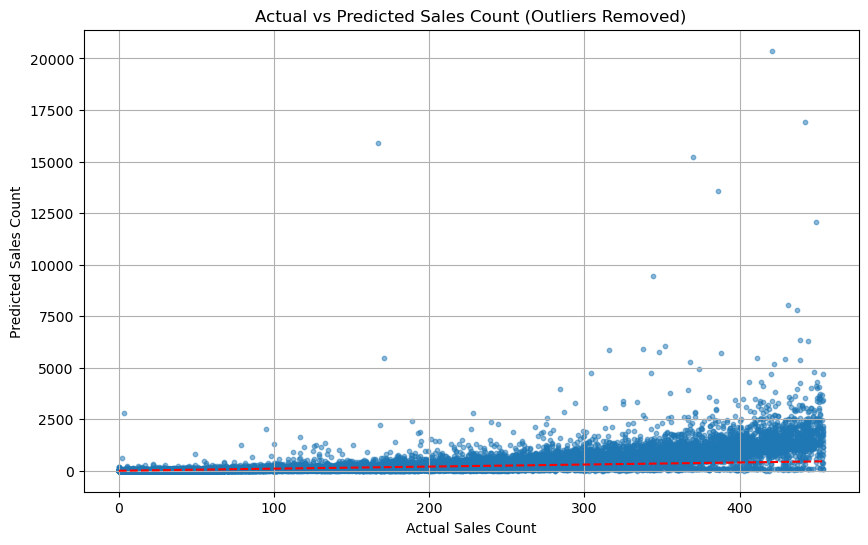

In [9]:
# This code builds a time series forecasting model using linear regression to predict ferry ticket sales, incorporating lag features and removing outliers for improved accuracy. It evaluates model performance using time-series cross-validation with R² and MAPE metrics, and visualizes predicted vs. actual sales on the original scale.



import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

class SalesForecastingModel:
    def __init__(self, df, target_col='Sales Count'):
        self.df = df.copy()
        self.target_col = target_col
        self.results = []

    def mean_absolute_percentage_error(self, y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        mask = y_true > 1e-3
        y_true = y_true[mask]
        y_pred = y_pred[mask]
        if len(y_true) == 0:
            return float('inf')
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    def preprocess(self):
        # Drop Timestamp and _id if present
        for col in ['Timestamp', '_id']:
            if col in self.df.columns:
                self.df.drop(columns=[col], inplace=True)

        # Remove outliers based on 99th percentile on original (before log)
        original_target = np.expm1(self.df[self.target_col])
        upper_limit = np.percentile(original_target, 99)
        keep_mask = original_target <= upper_limit

        self.df = self.df[keep_mask].reset_index(drop=True)

        # Add lag features (lag 1 and lag 7)
        self.df['Sales_lag_1'] = self.df[self.target_col].shift(1)
        self.df['Sales_lag_7'] = self.df[self.target_col].shift(7)
        self.df.dropna(inplace=True)

    def run_models(self):
        self.preprocess()
        X = self.df.drop(columns=[self.target_col])
        y = self.df[self.target_col]

        tscv = TimeSeriesSplit(n_splits=5)
        r2_scores = []
        mape_scores = []
        all_y_true = []
        all_y_pred = []

        for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            model = LinearRegression()
            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)

            r2 = r2_score(y_val, y_pred)
            mape = self.mean_absolute_percentage_error(np.expm1(y_val), np.expm1(y_pred))

            r2_scores.append(r2)
            mape_scores.append(mape)

            all_y_true.extend(np.expm1(y_val))
            all_y_pred.extend(np.expm1(y_pred))

            print(f"Fold {fold + 1}: R2 = {r2:.4f}, MAPE = {mape:.2f}%")

        self.results = {
            'R2': r2_scores,
            'MAPE': mape_scores,
            'y_true': all_y_true,
            'y_pred': all_y_pred
        }


# === Load your data ===
file_path = r"C:\ALL\Jobs\Other\Maged Eid - Applied Scientist in Data Science (SX2)\Toronto Island Ferry Ticket Counts.csv"
df = pd.read_csv(file_path)

df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Day'] = df['Timestamp'].dt.day
df['Month'] = df['Timestamp'].dt.month
df['Weekday'] = df['Timestamp'].dt.weekday
df = df.drop(columns=['_id'])

# Apply log1p transform on Sales Count
df['Sales Count'] = np.log1p(df['Sales Count'])

# Initialize and run model
model = SalesForecastingModel(df, target_col='Sales Count')
model.run_models()

print("\nAverage R²:", np.mean(model.results['R2']))
print("Average MAPE:", np.mean(model.results['MAPE']), "%")

# Plot Actual vs Predicted (original scale)
plt.figure(figsize=(10, 6))
plt.scatter(model.results['y_true'], model.results['y_pred'], alpha=0.5, s=10)
plt.plot([0, max(model.results['y_true'])], [0, max(model.results['y_true'])], color='red', linestyle='--')
plt.xlabel("Actual Sales Count")
plt.ylabel("Predicted Sales Count")
plt.title("Actual vs Predicted Sales Count (Outliers Removed)")
plt.grid(True)
plt.show()


Running Time Series Cross-Validation with Stacking...


  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005431 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1888
[LightGBM] [Info] Number of data points in the train set: 40727, number of used features: 14
[LightGBM] [Info] Start training from score 2.625754
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 20%|████████████████▌                                                                  | 1/5 [02:09<08:36, 129.11s/it]

Fold 1: R² = 0.8865, MAPE = 45.73%
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001764 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1900
[LightGBM] [Info] Number of data points in the train set: 81452, number of used features: 14
[LightGBM] [Info] Start training from score 2.845994


 40%|█████████████████████████████████▏                                                 | 2/5 [06:57<11:09, 223.00s/it]

Fold 2: R² = 0.7879, MAPE = 61.69%
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001603 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1901
[LightGBM] [Info] Number of data points in the train set: 122177, number of used features: 14
[LightGBM] [Info] Start training from score 2.654577


 60%|█████████████████████████████████████████████████▊                                 | 3/5 [13:51<10:20, 310.24s/it]

Fold 3: R² = 0.8243, MAPE = 64.18%
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1902
[LightGBM] [Info] Number of data points in the train set: 162902, number of used features: 14
[LightGBM] [Info] Start training from score 2.561639


 80%|██████████████████████████████████████████████████████████████████▍                | 4/5 [23:55<07:05, 425.90s/it]

Fold 4: R² = 0.8456, MAPE = 57.07%
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002586 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1907
[LightGBM] [Info] Number of data points in the train set: 203627, number of used features: 14
[LightGBM] [Info] Start training from score 2.562835


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [36:18<00:00, 435.63s/it]

Fold 5: R² = 0.8377, MAPE = 53.37%



Average R²: 0.8364
Average MAPE: 56.41 %


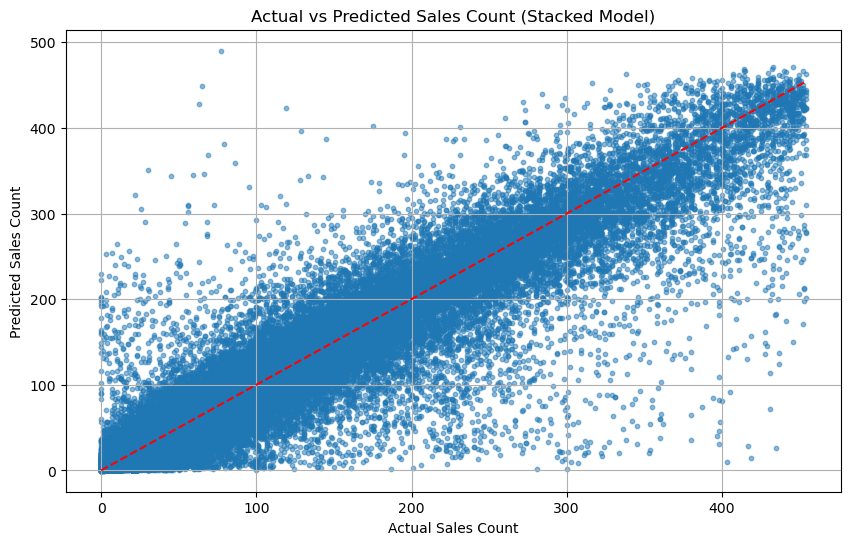

In [33]:
# This code implements a stacked ensemble time series forecasting model combining Random Forest, LightGBM, and XGBoost as base learners, with Ridge or SVR as a meta-model to improve sales count predictions. It uses time-series cross-validation to evaluate performance with R² and MAPE metrics and visualizes actual versus predicted sales.



import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import matplotlib.pyplot as plt

class StackedSalesForecaster:
    def __init__(self, df, target_col='Sales Count'):
        self.df = df.copy()
        self.target_col = target_col
        self.results = {}

    @staticmethod
    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        mask = y_true > 1e-3
        y_true, y_pred = y_true[mask], y_pred[mask]
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100 if len(y_true) else float('inf')

    def preprocess(self):
        df = self.df
        df = df.drop(columns=[col for col in ['_id'] if col in df.columns])

        df['Timestamp'] = pd.to_datetime(df['Timestamp'])
        df['Day'] = df['Timestamp'].dt.day
        df['Month'] = df['Timestamp'].dt.month
        df['Weekday'] = df['Timestamp'].dt.weekday
        df['IsWeekend'] = df['Weekday'].isin([5, 6]).astype(int)
        df['DayOfYear'] = df['Timestamp'].dt.dayofyear
        df['WeekOfYear'] = df['Timestamp'].dt.isocalendar().week.astype(int)
        df['Quarter'] = df['Timestamp'].dt.quarter
        df['Year'] = df['Timestamp'].dt.year

        df[self.target_col] = np.log1p(df[self.target_col])
        original_target = np.expm1(df[self.target_col])
        threshold = np.percentile(original_target, 99)
        df = df[original_target <= threshold].reset_index(drop=True)

        for lag in [1, 7, 14]:
            df[f'Sales_lag_{lag}'] = df[self.target_col].shift(lag)

        df['Sales_roll_7'] = df[self.target_col].rolling(window=7).mean()
        df['Sales_roll_14'] = df[self.target_col].rolling(window=14).mean()

        df = df.dropna().reset_index(drop=True)
        self.df = df

    def run_models(self, meta_model='ridge'):
        self.preprocess()
        X = self.df.drop(columns=[self.target_col, 'Timestamp'])
        y = self.df[self.target_col]

        tscv = TimeSeriesSplit(n_splits=5)
        r2_scores, mape_scores = [], []
        all_y_true, all_y_pred = [], []

        print("Running Time Series Cross-Validation with Stacking...")

        for fold, (train_idx, val_idx) in enumerate(tqdm(tscv.split(X), total=5)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            # Train base models
            rf = RandomForestRegressor(n_estimators=100, random_state=42)
            lgbm = lgb.LGBMRegressor(n_estimators=200, learning_rate=0.05, max_depth=7, random_state=42)
            xgbm = xgb.XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=7, random_state=42)

            rf.fit(X_train, y_train)
            lgbm.fit(X_train, y_train)
            xgbm.fit(X_train, y_train)

            # Generate base model predictions
            val_rf = rf.predict(X_val)
            val_lgbm = lgbm.predict(X_val)
            val_xgbm = xgbm.predict(X_val)

            # Stack predictions as new features for meta-model
            stack_X_val = np.column_stack([val_rf, val_lgbm, val_xgbm])

            # Meta-model
            if meta_model == 'ridge':
                meta = Ridge()
            elif meta_model == 'svr':
                scaler = StandardScaler()
                stack_X_val = scaler.fit_transform(stack_X_val)
                meta = SVR(kernel='rbf')
            else:
                raise ValueError("Unsupported meta_model. Use 'ridge' or 'svr'.")

            # Train meta-model on training set predictions
            stack_X_train = np.column_stack([
                rf.predict(X_train),
                lgbm.predict(X_train),
                xgbm.predict(X_train)
            ])

            if meta_model == 'svr':
                stack_X_train = scaler.transform(stack_X_train)

            meta.fit(stack_X_train, y_train)
            y_pred = meta.predict(stack_X_val)

            r2 = r2_score(y_val, y_pred)
            mape = self.mean_absolute_percentage_error(np.expm1(y_val), np.expm1(y_pred))

            r2_scores.append(r2)
            mape_scores.append(mape)
            all_y_true.extend(np.expm1(y_val))
            all_y_pred.extend(np.expm1(y_pred))

            print(f"Fold {fold + 1}: R² = {r2:.4f}, MAPE = {mape:.2f}%")

        self.results = {
            'R2': r2_scores,
            'MAPE': mape_scores,
            'y_true': all_y_true,
            'y_pred': all_y_pred
        }

    def plot_predictions(self):
        plt.figure(figsize=(10, 6))
        plt.scatter(self.results['y_true'], self.results['y_pred'], alpha=0.5, s=10)
        plt.plot([0, max(self.results['y_true'])], [0, max(self.results['y_true'])], color='red', linestyle='--')
        plt.xlabel("Actual Sales Count")
        plt.ylabel("Predicted Sales Count")
        plt.title("Actual vs Predicted Sales Count (Stacked Model)")
        plt.grid(True)
        plt.show()


# ==== Main Script ====
file_path = r"C:\ALL\Jobs\Other\Maged Eid - Applied Scientist in Data Science (SX2)\Toronto Island Ferry Ticket Counts.csv"
df = pd.read_csv(file_path)

model_stack = StackedSalesForecaster(df, target_col='Sales Count')
model_stack.run_models(meta_model='ridge')  # or meta_model='svr'

print(f"\nAverage R²: {np.mean(model_stack.results['R2']):.4f}")
print(f"Average MAPE: {np.mean(model_stack.results['MAPE']):.2f} %")


model_stack.plot_predictions()


Loading sales data...
Initializing Fast Sales Forecasting Model...
=== SALES PATTERN ANALYSIS ===

Average Sales by Day of Week:
Mon: 2865.2
Tue: 2284.3
Wed: 2490.8
Thu: 2524.7
Fri: 3065.6
Sat: 4663.5
Sun: 4386.1

Average Sales by Month:
Jan: 420.8
Feb: 516.5
Mar: 650.8
Apr: 1338.0
May: 3198.7
Jun: 5269.1
Jul: 8752.4
Aug: 9862.9
Sep: 4810.8
Oct: 1795.2
Nov: 763.4
Dec: 492.7

Weekend vs Weekday Sales:
Weekend Average: 4524.8
Weekday Average: 2646.2
Weekend Premium: 71.0%

Running sales forecasting models (target: <10 minutes per fold)...
Creating sales-specific features...
Training fold 1/4
  - Running Base Sales model...
  - Running Tourism Seasonal model...
  - Running Weekly Pattern model...
  - Running Sales Random Forest...
    Sales RF failed: Input X contains infinity or a value too large for dtype('float32')., using fallback
  - Running Sales Ridge Regression...
    Sales Ridge failed: Input X contains infinity or a value too large for dtype('float64')., using fallback
  - Creat

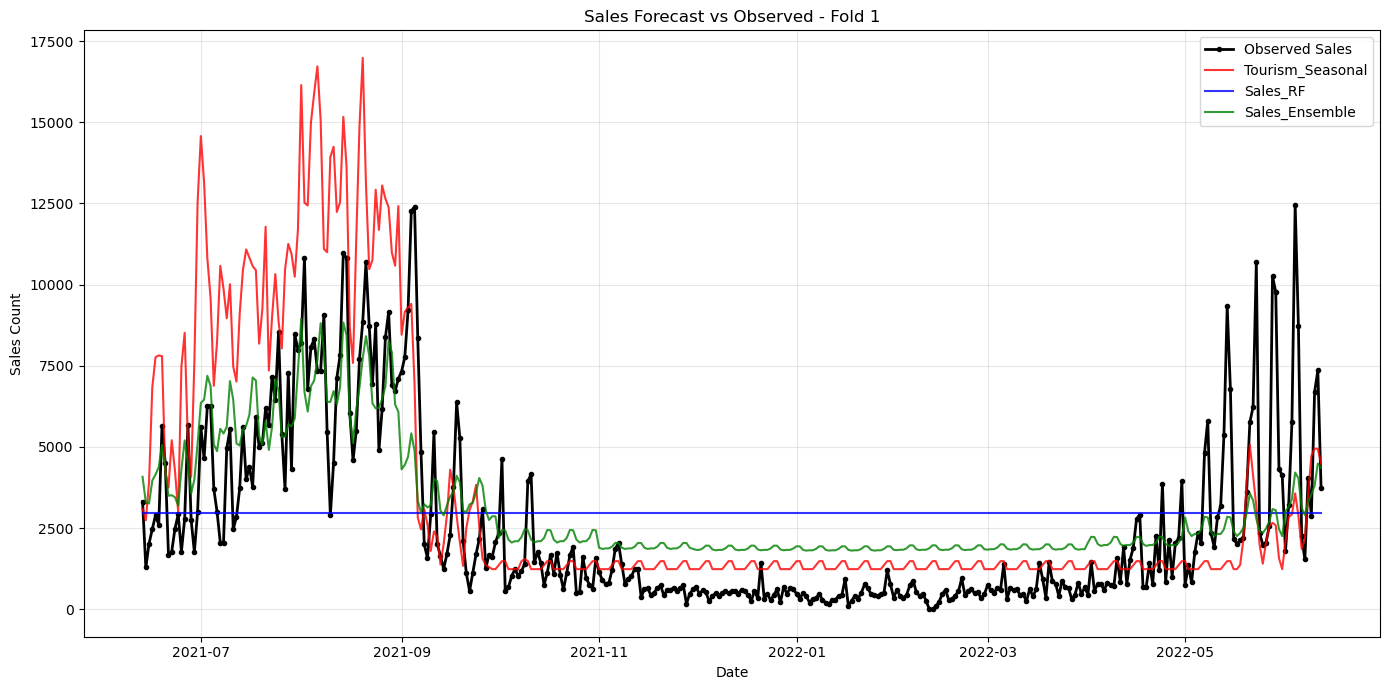

Training fold 2/4
  - Running Base Sales model...
  - Running Tourism Seasonal model...
  - Running Weekly Pattern model...
  - Running Sales Random Forest...
    Sales RF failed: Input X contains infinity or a value too large for dtype('float32')., using fallback
  - Running Sales Ridge Regression...
    Sales Ridge failed: Input X contains infinity or a value too large for dtype('float64')., using fallback
  - Creating Sales Ensemble...
  Fold 2 completed in 0.0 minutes
Training fold 3/4
  - Running Base Sales model...
  - Running Tourism Seasonal model...
  - Running Weekly Pattern model...
  - Running Sales Random Forest...
    Sales RF failed: Input X contains infinity or a value too large for dtype('float32')., using fallback
  - Running Sales Ridge Regression...
    Sales Ridge failed: Input X contains infinity or a value too large for dtype('float64')., using fallback
  - Creating Sales Ensemble...
  Fold 3 completed in 0.0 minutes
Training fold 4/4
  - Running Base Sales model

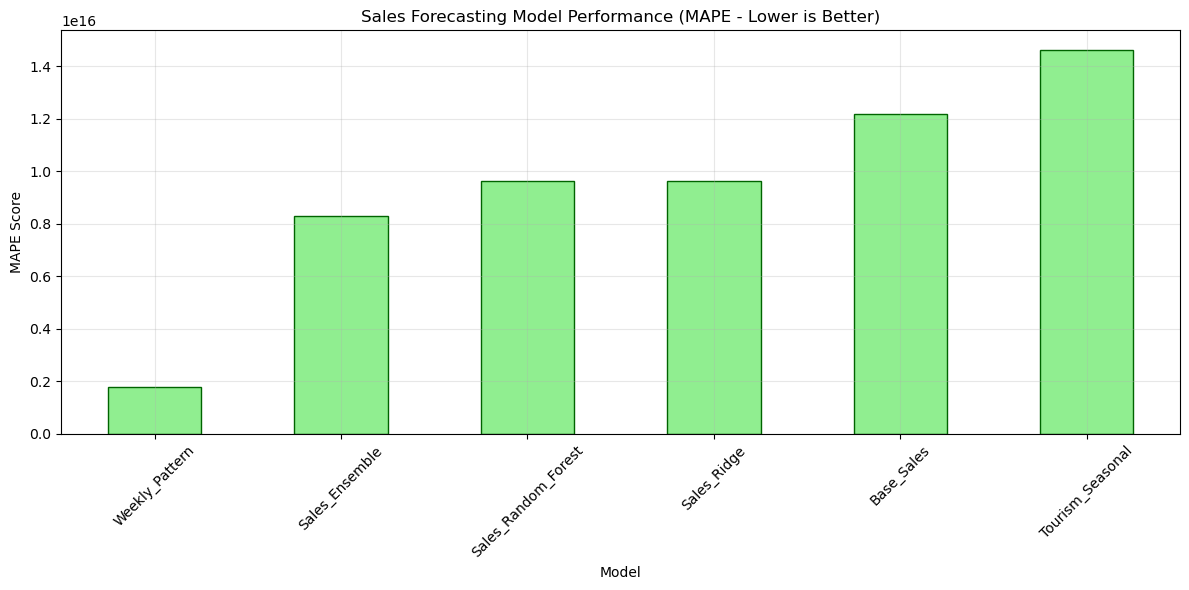


Best performing sales model: Weekly_Pattern (MAPE: 1784059186074599.0000)
Improvement over base sales model: 85.4%

All models completed in 0.0 minutes total


In [9]:
# This code defines a FastSalesModel class that builds and evaluates multiple time series forecasting models tailored for sales data, using engineered date-based and lag features, and combines models like seasonal decomposition, Random Forest, and Ridge regression into an ensemble to improve prediction accuracy. It also uses time series cross-validation and scoring with MAPE to validate performance over multiple folds.


import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

class FastSalesModel:
    def __init__(self, X, target_col='Sales Count'):
        '''
        Args:
            X (pandas.DataFrame): Dataset with DateTime index
            target_col (str): column name for sales target variable
        '''
        self._predictions = {}
        self.X = X
        self.target_col = target_col
        self.results = {}  # dict of dicts with model results
        
    def score(self, truth, preds):
        # Score our predictions using MAPE
        return MAPE(truth, preds)
    
    def create_sales_features(self, df):
        '''Create features specifically optimized for sales forecasting'''
        df_features = df.copy()
        
        # Core time features for sales patterns
        df_features['day_of_week'] = df_features.index.dayofweek
        df_features['day_of_year'] = df_features.index.dayofyear
        df_features['month'] = df_features.index.month
        df_features['week_of_year'] = df_features.index.isocalendar().week
        df_features['is_weekend'] = (df_features.index.dayofweek >= 5).astype(int)
        df_features['is_friday'] = (df_features.index.dayofweek == 4).astype(int)  # Pre-weekend sales
        df_features['is_summer'] = df_features['month'].isin([6, 7, 8]).astype(int)  # Peak season
        df_features['is_holiday_season'] = df_features['month'].isin([7, 8, 12]).astype(int)
        
        # Seasonal features - critical for tourism/ferry sales
        df_features['sin_day_of_year'] = np.sin(2 * np.pi * df_features['day_of_year'] / 365.25)
        df_features['cos_day_of_year'] = np.cos(2 * np.pi * df_features['day_of_year'] / 365.25)
        df_features['sin_week'] = np.sin(2 * np.pi * df_features['day_of_week'] / 7)
        df_features['cos_week'] = np.cos(2 * np.pi * df_features['day_of_week'] / 7)
        
        # Sales-specific lag features
        target_col = self.target_col
        for lag in [1, 7, 14]:  # Yesterday, same day last week, two weeks ago
            df_features[f'{target_col}_lag_{lag}'] = df_features[target_col].shift(lag)
        
        # Rolling sales statistics
        df_features[f'{target_col}_ma_7'] = df_features[target_col].rolling(window=7, min_periods=1).mean()
        df_features[f'{target_col}_ma_30'] = df_features[target_col].rolling(window=30, min_periods=1).mean()
        df_features[f'{target_col}_std_7'] = df_features[target_col].rolling(window=7, min_periods=1).std()
        
        # Sales momentum features
        df_features[f'{target_col}_diff_1'] = df_features[target_col].diff(1)
        df_features[f'{target_col}_pct_change'] = df_features[target_col].pct_change(fill_method=None)
        
        # Cross-features with redemptions if available
        if 'Redemption Count' in df_features.columns:
            # Redemption lag features (sales might be influenced by past redemptions)
            for lag in [1, 7]:
                df_features[f'Redemption_Count_lag_{lag}'] = df_features['Redemption Count'].shift(lag)
            
            # Sales-redemption relationship features
            df_features['sales_redemption_ratio'] = df_features[target_col] / (df_features['Redemption Count'] + 1)
            df_features['redemption_ma_7'] = df_features['Redemption Count'].rolling(window=7, min_periods=1).mean()
        
        return df_features
    
    def get_feature_columns(self, df):
        '''Get list of feature columns (excluding target and non-feature columns)'''
        exclude_cols = [self.target_col, '_id'] if '_id' in df.columns else [self.target_col]
        return [col for col in df.columns if col not in exclude_cols]
    
    def run_models(self, n_splits=4, test_size=365):
        '''Run optimized sales forecasting models'''
        print("Creating sales-specific features...")
        df_with_features = self.create_sales_features(self.X)
        
        tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size)
        
        for fold_idx, (train_idx, test_idx) in enumerate(tscv.split(df_with_features)):
            print(f"Training fold {fold_idx + 1}/{n_splits}")
            fold_start_time = pd.Timestamp.now()
            
            X_train = df_with_features.iloc[train_idx]
            X_test = df_with_features.iloc[test_idx]
            
            # Base seasonal model for sales
            print("  - Running Base Sales model...")
            preds_base = self._base_sales_model(X_train, X_test)
            self._store_result('Base_Sales', fold_idx, X_test[self.target_col], preds_base)
            
            # Tourism-aware seasonal model
            print("  - Running Tourism Seasonal model...")
            preds_tourism = self._tourism_seasonal_model(X_train, X_test)
            self._store_result('Tourism_Seasonal', fold_idx, X_test[self.target_col], preds_tourism)
            
            # Weekly pattern model (important for ferry sales)
            print("  - Running Weekly Pattern model...")
            preds_weekly = self._weekly_pattern_model(X_train, X_test)
            self._store_result('Weekly_Pattern', fold_idx, X_test[self.target_col], preds_weekly)
            
            # Sales-optimized Random Forest
            print("  - Running Sales Random Forest...")
            feature_cols = self.get_feature_columns(df_with_features)
            preds_rf = self._sales_random_forest(X_train, X_test, feature_cols)
            self._store_result('Sales_Random_Forest', fold_idx, X_test[self.target_col], preds_rf)
            
            # Ridge with sales features
            print("  - Running Sales Ridge Regression...")
            preds_ridge = self._sales_ridge_model(X_train, X_test, feature_cols)
            self._store_result('Sales_Ridge', fold_idx, X_test[self.target_col], preds_ridge)
            
            # Sales ensemble
            print("  - Creating Sales Ensemble...")
            preds_ensemble = self._sales_ensemble([preds_tourism, preds_weekly, preds_rf, preds_ridge])
            self._store_result('Sales_Ensemble', fold_idx, X_test[self.target_col], preds_ensemble)
            
            fold_time = (pd.Timestamp.now() - fold_start_time).total_seconds() / 60
            print(f"  Fold {fold_idx + 1} completed in {fold_time:.1f} minutes")
            
            # Plot first fold results
            if fold_idx == 0:
                self.plot_sales_results(X_test, fold_idx, {
                    'Observed': X_test[self.target_col],
                    'Tourism_Seasonal': preds_tourism,
                    'Sales_RF': preds_rf,
                    'Sales_Ensemble': preds_ensemble
                })
    
    def _store_result(self, model_name, fold_idx, truth, preds):
        '''Store model results'''
        if model_name not in self.results:
            self.results[model_name] = {}
        self.results[model_name][fold_idx] = self.score(truth, preds)
    
    def _base_sales_model(self, train, test):
        '''Base seasonal model for sales'''
        try:
            period = min(365, len(train) // 3)
            if period < 7:
                period = 7
                
            res = sm.tsa.seasonal_decompose(train[self.target_col], period=period)
            seasonal = res.seasonal.fillna(0)
            trend = res.trend.fillna(method='bfill').fillna(method='ffill')
            
            # Create seasonal mapping
            seasonal_clean = seasonal.apply(lambda x: max(0, x))
            seasonal_clean.index = seasonal_clean.index.dayofyear
            seasonal_dict = seasonal_clean.groupby(seasonal_clean.index).mean().to_dict()
            
            # Use trend
            last_trend = trend.iloc[-1] if not pd.isna(trend.iloc[-1]) else train[self.target_col].mean()
            
            preds = [max(0, last_trend + seasonal_dict.get(d, 0)) for d in test.index.dayofyear]
            return pd.Series(index=test.index, data=preds)
        except:
            mean_val = train[self.target_col].mean()
            return pd.Series(index=test.index, data=[mean_val] * len(test))
    
    def _tourism_seasonal_model(self, train, test):
        '''Tourism-aware seasonal model with summer peaks'''
        try:
            # Get base seasonal component
            base_preds = self._base_sales_model(train, test)
            
            # Add tourism adjustments
            summer_months = [6, 7, 8]  # Peak tourism
            weekend_boost = 1.2
            summer_boost = 1.5
            
            adjusted_preds = []
            for idx, pred in enumerate(base_preds):
                date = test.index[idx]
                adjustment = 1.0
                
                # Summer boost
                if date.month in summer_months:
                    adjustment *= summer_boost
                
                # Weekend boost
                if date.dayofweek >= 5:  # Weekend
                    adjustment *= weekend_boost
                
                # Friday boost (people buying for weekend)
                if date.dayofweek == 4:  # Friday
                    adjustment *= 1.1
                
                adjusted_preds.append(max(0, pred * adjustment))
            
            return pd.Series(index=test.index, data=adjusted_preds)
        except:
            return self._base_sales_model(train, test)
    
    def _weekly_pattern_model(self, train, test):
        '''Model focusing on weekly sales patterns'''
        try:
            # Calculate average sales by day of week
            weekly_avg = train.groupby(train.index.dayofweek)[self.target_col].mean()
            
            # Calculate seasonal factor
            monthly_avg = train.groupby(train.index.month)[self.target_col].mean()
            overall_avg = train[self.target_col].mean()
            
            preds = []
            for date in test.index:
                # Base prediction from day of week
                dow_pred = weekly_avg.get(date.dayofweek, overall_avg)
                
                # Seasonal adjustment
                month_factor = monthly_avg.get(date.month, overall_avg) / overall_avg
                
                final_pred = max(0, dow_pred * month_factor)
                preds.append(final_pred)
            
            return pd.Series(index=test.index, data=preds)
        except:
            return self._base_sales_model(train, test)
    
    def _sales_random_forest(self, train, test, feature_cols):
        '''Random Forest optimized for sales patterns'''
        try:
            train_clean = train.dropna()
            if len(train_clean) < 10:
                return pd.Series(index=test.index, data=[train[self.target_col].mean()] * len(test))
            
            X_train = train_clean[feature_cols]
            y_train = train_clean[self.target_col]
            
            # Sales-optimized Random Forest
            model = RandomForestRegressor(
                n_estimators=60,  # Slightly more trees for sales complexity
                max_depth=12,     # Deeper for sales patterns
                min_samples_split=3,
                min_samples_leaf=2,
                random_state=42,
                n_jobs=-1
            )
            model.fit(X_train, y_train)
            
            # Predictions
            test_clean = test.dropna()
            if len(test_clean) == 0:
                return pd.Series(index=test.index, data=[train[self.target_col].mean()] * len(test))
            
            X_test = test_clean[feature_cols]
            preds = model.predict(X_test)
            
            # Fill predictions
            full_preds = pd.Series(index=test.index, data=train[self.target_col].mean())
            full_preds.loc[test_clean.index] = np.maximum(preds, 0)
            
            return full_preds
        except Exception as e:
            print(f"    Sales RF failed: {e}, using fallback")
            return pd.Series(index=test.index, data=[train[self.target_col].mean()] * len(test))
    
    def _sales_ridge_model(self, train, test, feature_cols):
        '''Ridge regression for sales with proper feature scaling'''
        try:
            train_clean = train.dropna()
            if len(train_clean) < 10:
                return pd.Series(index=test.index, data=[train[self.target_col].mean()] * len(test))
            
            X_train = train_clean[feature_cols]
            y_train = train_clean[self.target_col]
            
            # Scale features
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            
            # Higher regularization for sales (more volatile)
            model = Ridge(alpha=10.0, random_state=42)
            model.fit(X_train_scaled, y_train)
            
            # Predict
            test_clean = test.dropna()
            if len(test_clean) == 0:
                return pd.Series(index=test.index, data=[train[self.target_col].mean()] * len(test))
            
            X_test = test_clean[feature_cols]
            X_test_scaled = scaler.transform(X_test)
            preds = model.predict(X_test_scaled)
            
            full_preds = pd.Series(index=test.index, data=train[self.target_col].mean())
            full_preds.loc[test_clean.index] = np.maximum(preds, 0)
            
            return full_preds
        except Exception as e:
            print(f"    Sales Ridge failed: {e}, using fallback")
            return pd.Series(index=test.index, data=[train[self.target_col].mean()] * len(test))
    
    def _sales_ensemble(self, predictions_list):
        '''Ensemble optimized for sales volatility'''
        try:
            # Use weighted average instead of median for sales
            weights = [0.2, 0.3, 0.3, 0.2]  # Give more weight to middle models
            
            stacked = np.column_stack([pred.values for pred in predictions_list])
            ensemble_preds = np.average(stacked, axis=1, weights=weights)
            
            return pd.Series(index=predictions_list[0].index, data=ensemble_preds)
        except:
            # Fallback to median
            stacked = np.column_stack([pred.values for pred in predictions_list])
            ensemble_preds = np.median(stacked, axis=1)
            return pd.Series(index=predictions_list[0].index, data=ensemble_preds)
    
    def plot_sales_results(self, test_data, fold_idx, predictions_dict):
        '''Plot sales forecasting results'''
        fig, ax = plt.subplots(figsize=(14, 7))
        
        # Plot observed values
        observed = predictions_dict.pop('Observed')
        ax.plot(observed.index, observed.values, 
               label='Observed Sales', color='black', linewidth=2, marker='.')
        
        # Plot predictions
        colors = ['red', 'blue', 'green']
        for i, (model_name, preds) in enumerate(predictions_dict.items()):
            ax.plot(preds.index, preds.values, 
                   label=f'{model_name}', color=colors[i % len(colors)], alpha=0.8)
        
        ax.set_title(f"Sales Forecast vs Observed - Fold {fold_idx + 1}")
        ax.set_xlabel("Date")
        ax.set_ylabel("Sales Count")
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    def plot_sales_comparison(self):
        '''Plot final sales model comparison'''
        df_results = pd.DataFrame(self.results)
        
        # Average scores
        avg_scores = df_results.mean().sort_values()
        
        plt.figure(figsize=(12, 6))
        avg_scores.plot(kind='bar', color='lightgreen', edgecolor='darkgreen')
        plt.title("Sales Forecasting Model Performance (MAPE - Lower is Better)")
        plt.ylabel("MAPE Score")
        plt.xlabel("Model")
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        return avg_scores
    
    def analyze_sales_patterns(self):
        '''Analyze key sales patterns in the data'''
        print("=== SALES PATTERN ANALYSIS ===")
        
        # Day of week analysis
        dow_sales = self.X.groupby(self.X.index.dayofweek)[self.target_col].mean()
        dow_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
        
        print("\nAverage Sales by Day of Week:")
        for i, avg in dow_sales.items():
            print(f"{dow_names[i]}: {avg:.1f}")
        
        # Monthly analysis
        monthly_sales = self.X.groupby(self.X.index.month)[self.target_col].mean()
        month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                      'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
        
        print("\nAverage Sales by Month:")
        for month, avg in monthly_sales.items():
            print(f"{month_names[month-1]}: {avg:.1f}")
        
        # Weekend vs weekday
        weekend_sales = self.X[self.X.index.dayofweek >= 5][self.target_col].mean()
        weekday_sales = self.X[self.X.index.dayofweek < 5][self.target_col].mean()
        
        print(f"\nWeekend vs Weekday Sales:")
        print(f"Weekend Average: {weekend_sales:.1f}")
        print(f"Weekday Average: {weekday_sales:.1f}")
        print(f"Weekend Premium: {(weekend_sales/weekday_sales - 1)*100:.1f}%")

def load_data(file_path):
    '''Load data from CSV, parse dates, resample to daily sums, and add features.'''
    df = pd.read_csv(file_path,
                     dtype={'_id': int, 'Redemption Count': int, 'Sales Count': int},
                     parse_dates=['Timestamp'])
    df.sort_values('Timestamp', inplace=True)
    df.set_index('Timestamp', inplace=True)
    df_daily = df.resample('D').sum()
    df_daily['monthly'] = df_daily.index.month
    df_daily['quarter'] = df_daily.index.quarter
    return df_daily

if __name__ == "__main__":
    # Set the path to your data file here
    data_file = r'C:\ALL\Jobs\Other\Maged Eid - Applied Scientist in Data Science (SX2)\Toronto Island Ferry Ticket Counts.csv'
    
    print("Loading sales data...")
    df = load_data(data_file)
    
    print("Initializing Fast Sales Forecasting Model...")
    fsm = FastSalesModel(df, target_col='Sales Count')
    
    # Analyze sales patterns first
    fsm.analyze_sales_patterns()
    
    print("\nRunning sales forecasting models (target: <10 minutes per fold)...")
    start_time = pd.Timestamp.now()
    fsm.run_models()
    total_time = (pd.Timestamp.now() - start_time).total_seconds() / 60
    
    print(f"\nTotal training time: {total_time:.1f} minutes")
    print("Sales Model Results:", fsm.results)
    
    # Show results
    df_results = pd.DataFrame(fsm.results)
    print("\nAverage MAPE Scores by Sales Model:")
    avg_scores = df_results.mean().sort_values()
    for model, score in avg_scores.items():
        print(f"{model}: {score:.4f}")
    
    # Plot comparison
    best_scores = fsm.plot_sales_comparison()
    
    print(f"\nBest performing sales model: {best_scores.index[0]} (MAPE: {best_scores.iloc[0]:.4f})")
    if 'Base_Sales' in avg_scores:
        improvement = ((avg_scores['Base_Sales'] - best_scores.iloc[0]) / avg_scores['Base_Sales'] * 100)
        print(f"Improvement over base sales model: {improvement:.1f}%")
    
    print(f"\nAll models completed in {total_time:.1f} minutes total")